### **Part 4**
**Tasks**
* explore proper visual stimuli
  * spontaneous state
  * (done) evoked state: drifting
* Communication subspaces across different areas
  * (done) correlation
  * (done) dimensionality
    * intra_areas
    * inter_areas
* Information flow across subspaces
  * (done) direction: population correlation as the function of the time delay between areas ($t_2$-$t_1$)
  * intensity (correlation intensity)
* Hierarchy of information flow  across these subspaces
  * direction
    * (done) inter_areas cca_delay
    * *intra_areas cca_delay (layer_dependent)*
    * (done) feedfward and feedback
    * (done) input/output dimensions
  * function validation
* Relation between different information flow channels
  * *subspace & layer_dependent*
  * shared dimensionility
  * (done) generalize canonical dimension across subspaces
  * (done) subspaces angle
  * CCA across subspaces
  * predictive coding
* (to do) State dependent geometrical properties of these channels
* (to do) Dynamical system across areas modeled by multi-region RNN network

*************************************
(doing) 
* clear up code, make them beauty
* speed up code, make them faster
* generize code across areas and sessions/mice
************************************

In [1]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [23]:
def set_device(i):
  """
  Set the device. CUDA if available, CPU otherwise
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook.")
  else:
    print("GPU is enabled in this notebook.")
    if torch.cuda.device_count() >= i + 1:
      device = f'cuda:{i}'
  return device

DEVICE = set_device(0)
print('Num of gpu:', torch.cuda.device_count())

x = torch.tensor([0, 1, 2], device=DEVICE)
y = torch.tensor([3, 4, 5], device="cpu")
print('example:', y)
y = y.to(DEVICE)  # alternatively, you can use y = y.cuda()
print('example:', y)
x = x.to('cuda:1')
print('example:', x)

GPU is enabled in this notebook.
Num of gpu: 4
example: tensor([3, 4, 5])
example: tensor([3, 4, 5], device='cuda:0')
example: tensor([0, 1, 2], device='cuda:1')


### Task1 explore proper visual stimuli

In [2]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
session_ids = [719161530, 750332458, 750749662, 754312389, 755434585, 756029989, 791319847, 797828357]
selected_sessions = {}

for i, session_id in enumerate(session_ids):
    session = cache.get_session_data(session_id)
    selected_sessions[session_id] = session

In [3]:
def get_units_area(areas, session):

    units_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        units_area[i] = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]

    return units_area

def delete_bad_areas(session):

    areas = session.structure_acronyms
    print(len(areas))
    print(areas)

    # delete nan in areas
    while np.nan in areas:
        areas.remove(np.nan)

    # delete area with no units
    for area in areas:
        units = session.units[session.units["ecephys_structure_acronym"] == area]
        if units.shape[0] == 0:
            areas.remove(area)

    print(len(areas))
    print(areas)

    return areas

def plot_units_areas(units_areas, areas, session_ids):

    fig, axes = plt.subplots(nrows=len(session_ids), ncols=1, figsize=(12, 24))

    for i in range(len(session_ids)):
        
        axes[i].bar(range(len(areas)), units_areas[i, :], width=0.6)
        for x, y in zip(range(len(areas)), units_areas[i, :]):
            axes[i].text(x, y, y, ha='center', va='bottom', fontsize=13)
        axes[i].set_xticks(range(len(areas)))
        axes[i].set_xticklabels(areas, fontsize=13)
        axes[i].set_ylabel(f'units', fontsize=13)
        axes[i].set_ylim(0, np.max(units_areas[i, :])+10)
        axes[i].set_title(f'session {session_ids[i]}', fontsize=15)

    fig.suptitle('units across areas in different sessions', verticalalignment='bottom', fontsize=18)

    fig.tight_layout()
    plt.show()

    return

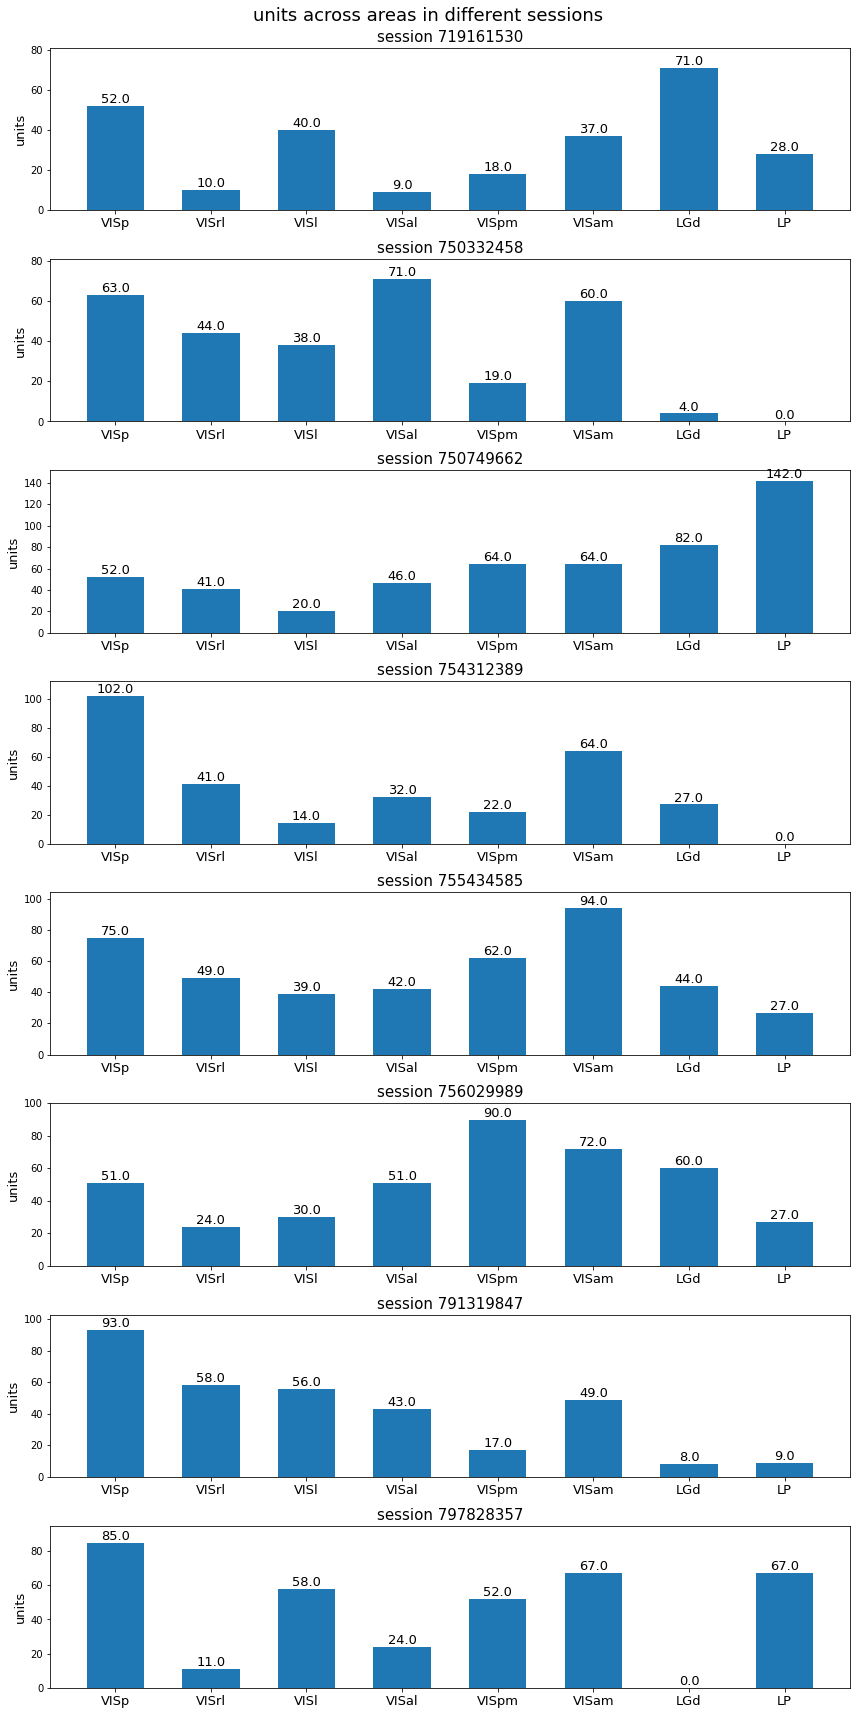

In [65]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
units_areas = np.zeros((len(session_ids), len(areas)))

for i, session_id in enumerate(session_ids):
    session = selected_sessions[session_id]
    units_areas[i, :] = get_units_area(areas, session)

plot_units_areas(units_areas, areas, session_ids)


In [4]:
session = selected_sessions[755434585]
drift_stim_table = session.get_stimulus_table('drifting_gratings')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,225,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1585.891887,2,drifting_gratings,1587.893537,1,2.00165,246
3799,0.8,270,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1588.894403,2,drifting_gratings,1590.896063,2,2.00166,247
3800,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1591.896927,2,drifting_gratings,1593.898597,8,2.00167,248
3801,0.8,0,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1594.899423,2,drifting_gratings,1596.901083,2,2.00166,249
3802,0.8,315,"[21235.93333333, 21235.93333333]","[250.0, 250.0]",0.04,1597.901957,2,drifting_gratings,1599.903567,2,2.00161,250


### Task2 CCA correlation across areas

In [5]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def get_design_matrix(area, stim_table):
    """get_design_matrix design_matrix for further analysis

    Reshape response_matrix from (stims, bins, units) to (stims*bins, units)/(n_samples, units)

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        design_matrix, shape (n_samples, units)
    """

    response_matrix = spike_matrix(area=area, stim_table=stim_table)
    design_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1],
                                    response_matrix.shape[2])

    return design_matrix

In [6]:
def corr_area_pairs(X_a, X_b, n_components=3):
    """corr_area_pairs cca between two areas' design matrix, X_a and X_b

    Arguments:
        X_a -- design matrix of one area, shape (stims*bins, units)
        X_b -- design matrix of one area, shape (stims*bins, units)

    Keyword Arguments:
        n_components -- num of canonical dimensions (default: {3})

    Returns:
        corr_z, correlation of latent variables, shape (n_components,)
        w_a, projection matrix used to transform X_a, shape (units_a, n_components)
        w_b, projection matrix used to transform X_b, shape (units_b, n_components) 
        z_a, canonical variables after projection X_a with w_a, shape (n_samples, n_components)
        z_b, canonical variables after projection X_b with w_b, shape (n_samples, n_components)
    """

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) # latent variables

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

def CCA_across_areas(stim_table, areas, component=0):
    
    areas_corr_matrix = np.empty([len(areas), len(areas)])

    for i in range(len(areas)):
        for j in range(len(areas)):
            des_mat_i = get_design_matrix(area = areas[i], stim_table=stim_table)
            des_mat_j = get_design_matrix(area = areas[j], stim_table=stim_table)

            corr_ij, _, _ = corr_area_pairs(des_mat_i, des_mat_j)
            areas_corr_matrix[i, j] = corr_ij[component]

    return areas_corr_matrix

def plot_CCA_across_areas(areas, areas_corr_matrix):

    f, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(areas_corr_matrix)

    ax.set_xticks(range(len(areas))+np.array([0.5]))
    ax.set_xticklabels(areas)
    ax.set_yticks(range(len(areas))+np.array([0.5]))
    ax.set_yticklabels(areas)
    ax.set_title(f'CCA 1st correlation between different area_pairs, with whole drifting stimuli')

    f.colorbar(im)

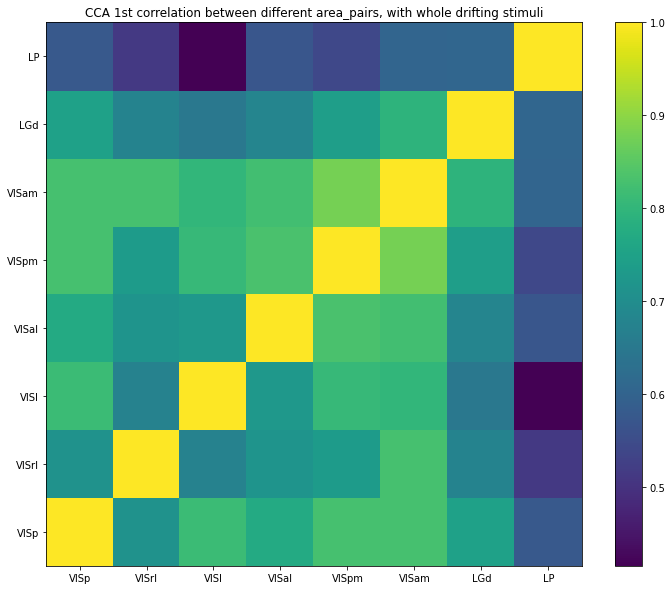

In [73]:
areas_corr_matrix = CCA_across_areas(stim_table=drift_stim_table, areas=areas)
plot_CCA_across_areas(areas, areas_corr_matrix)

### Task3 CCA correlation across areas with time_delay

In [7]:
def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes


def cca_delay_areas(area_1, area_2, stim_table, trial_len=2000, window_len=200, step_len=40, bin_len=50, max_delay=100):

    # correlation by delay when time bin = 1ms, with window 200ms, window slide advanced 40ms

    raster_bin = 1  # bin time, 1ms

    spike_raster_1 = spike_matrix(area=area_1, stim_table=stim_table, bin=raster_bin/1000)
    spike_raster_2 = spike_matrix(area=area_2, stim_table=stim_table, bin=raster_bin/1000)

    step_points = np.arange(0, trial_len-window_len, step_len)

    corr_matrix_delay = np.zeros((len(step_points), 2*max_delay))

    for step_id, step in enumerate(step_points):
        t_1 = step
        window_1 = np.arange(t_1, t_1+window_len)
        spike_counts_1 = spike_counts_bins(spike_raster_1[:, window_1, :], bin_len)
        spike_counts_1 = spike_counts_1.reshape([spike_counts_1.shape[0]*spike_counts_1.shape[1],
                                                spike_counts_1.shape[2]])

        slide_points = range(max(t_1-max_delay, 0), min(t_1+max_delay, trial_len-window_len))

        for slide_id, slide in enumerate(slide_points):
            t_2 = slide
            window_2 = np.arange(t_2, t_2+window_len)
            spike_counts_2 = spike_counts_bins(spike_raster_2[:, window_2, :], bin_len)
            spike_counts_2 = spike_counts_2.reshape([spike_counts_2.shape[0]*spike_counts_2.shape[1],
                                                spike_counts_2.shape[2]])

            corr, w, z = corr_area_pairs(spike_counts_1, spike_counts_2)
            corr_matrix_delay[step_id, t_2-t_1+max_delay] = corr[0]

    # print(corr_matrix_delay.shape)
    # mask no correlation value
    corr_matrix_delay = np.ma.masked_where(corr_matrix_delay == 0, corr_matrix_delay)

    return corr_matrix_delay


def get_feedforward_ratio(corr_matrix_delay, step=5):

    max_delay = int(corr_matrix_delay.shape[1]/2)
        
    negative_delay_area = np.sum(corr_matrix_delay[step, :max_delay])
    positive_delay_area = np.sum(corr_matrix_delay[step, max_delay:])

    feedforward_ratio = (positive_delay_area-negative_delay_area)/(positive_delay_area+negative_delay_area)

    return feedforward_ratio

In [8]:
def plot_corr_delay_matrix(corr_matrix_delay, area_1, area_2):
    
    max_delay = int(corr_matrix_delay.shape[1]/2)

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.pcolormesh(corr_matrix_delay)

    ax.set_xticks(range(0, corr_matrix_delay.shape[1], 20))
    ax.set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))
    # ax.set_yticks(range(len(areas))+np.array([0.5]))
    # ax.set_yticklabels(areas)
    ax.set_xlabel('delay, ms')
    ax.set_ylabel('step, *40ms')
    ax.set_title(f'correlation_delay between {area_1} & {area_2}')

    fig.colorbar(im)
    plt.show

    return

def plot_corr_delay(corr_matrix_delay, area_1, area_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    step_list = [5, 10, 20, 30, 39]

    fig, axes = plt.subplots(nrows=len(step_list), ncols=1, figsize=(24, 28))

    for i, step in enumerate(step_list):
        
        axes[i].plot(range(-max_delay, max_delay), corr_matrix_delay[step, :])
        axes[i].set_ylabel('corrlelation')
        axes[i].set_xlabel('delay, ms')
        axes[i].set_title(f'correlation_delay in step {step} between {area_1} & {area_2}')

    plt.tight_layout()
    plt.show()

    return

def plot_corr_step(corr_matrix_delay, area_1, area_2):

    max_delay = int(corr_matrix_delay.shape[1]/2)
    delay_list = [-80, -40, 0, 40, 80]

    fig, axes = plt.subplots(nrows=len(delay_list), ncols=1, figsize=(24, 28))

    for i, delay in enumerate(delay_list):
        
        axes[i].plot(range(corr_matrix_delay.shape[0]), corr_matrix_delay[:, delay+max_delay])
        axes[i].set_ylabel('corrlelation')
        axes[i].set_xlabel('step, *40ms')
        axes[i].set_title(f'correlation_step in delay {delay} between {area_1} & {area_2}')

    plt.tight_layout()
    plt.show()

    return


def plot_feedforward_ratio(corr_matrix_delay, area_1, area_2):

    step_list = [5, 10, 20, 30, 39]
    feedforward_ratio = np.zeros(len(step_list))

    for i, step in enumerate(step_list):

        feedforward_ratio[i] = get_feedforward_ratio(corr_matrix_delay, step=step)
    
    plt.figure()
    plt.plot(range(len(step_list)), feedforward_ratio)
    plt.xticks(ticks=np.arange(len(step_list))+[0.5], labels=step_list)
    plt.title(f'feedforward_ratio between {area_1} & {area_2}')
    plt.xlabel('step, *40ms')
    plt.ylabel('feedforward_ratio')
    plt.show

    return 

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations 

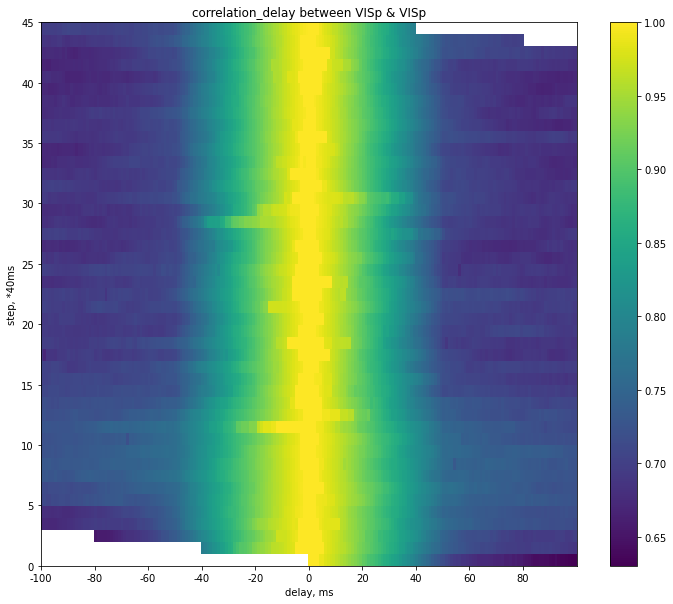

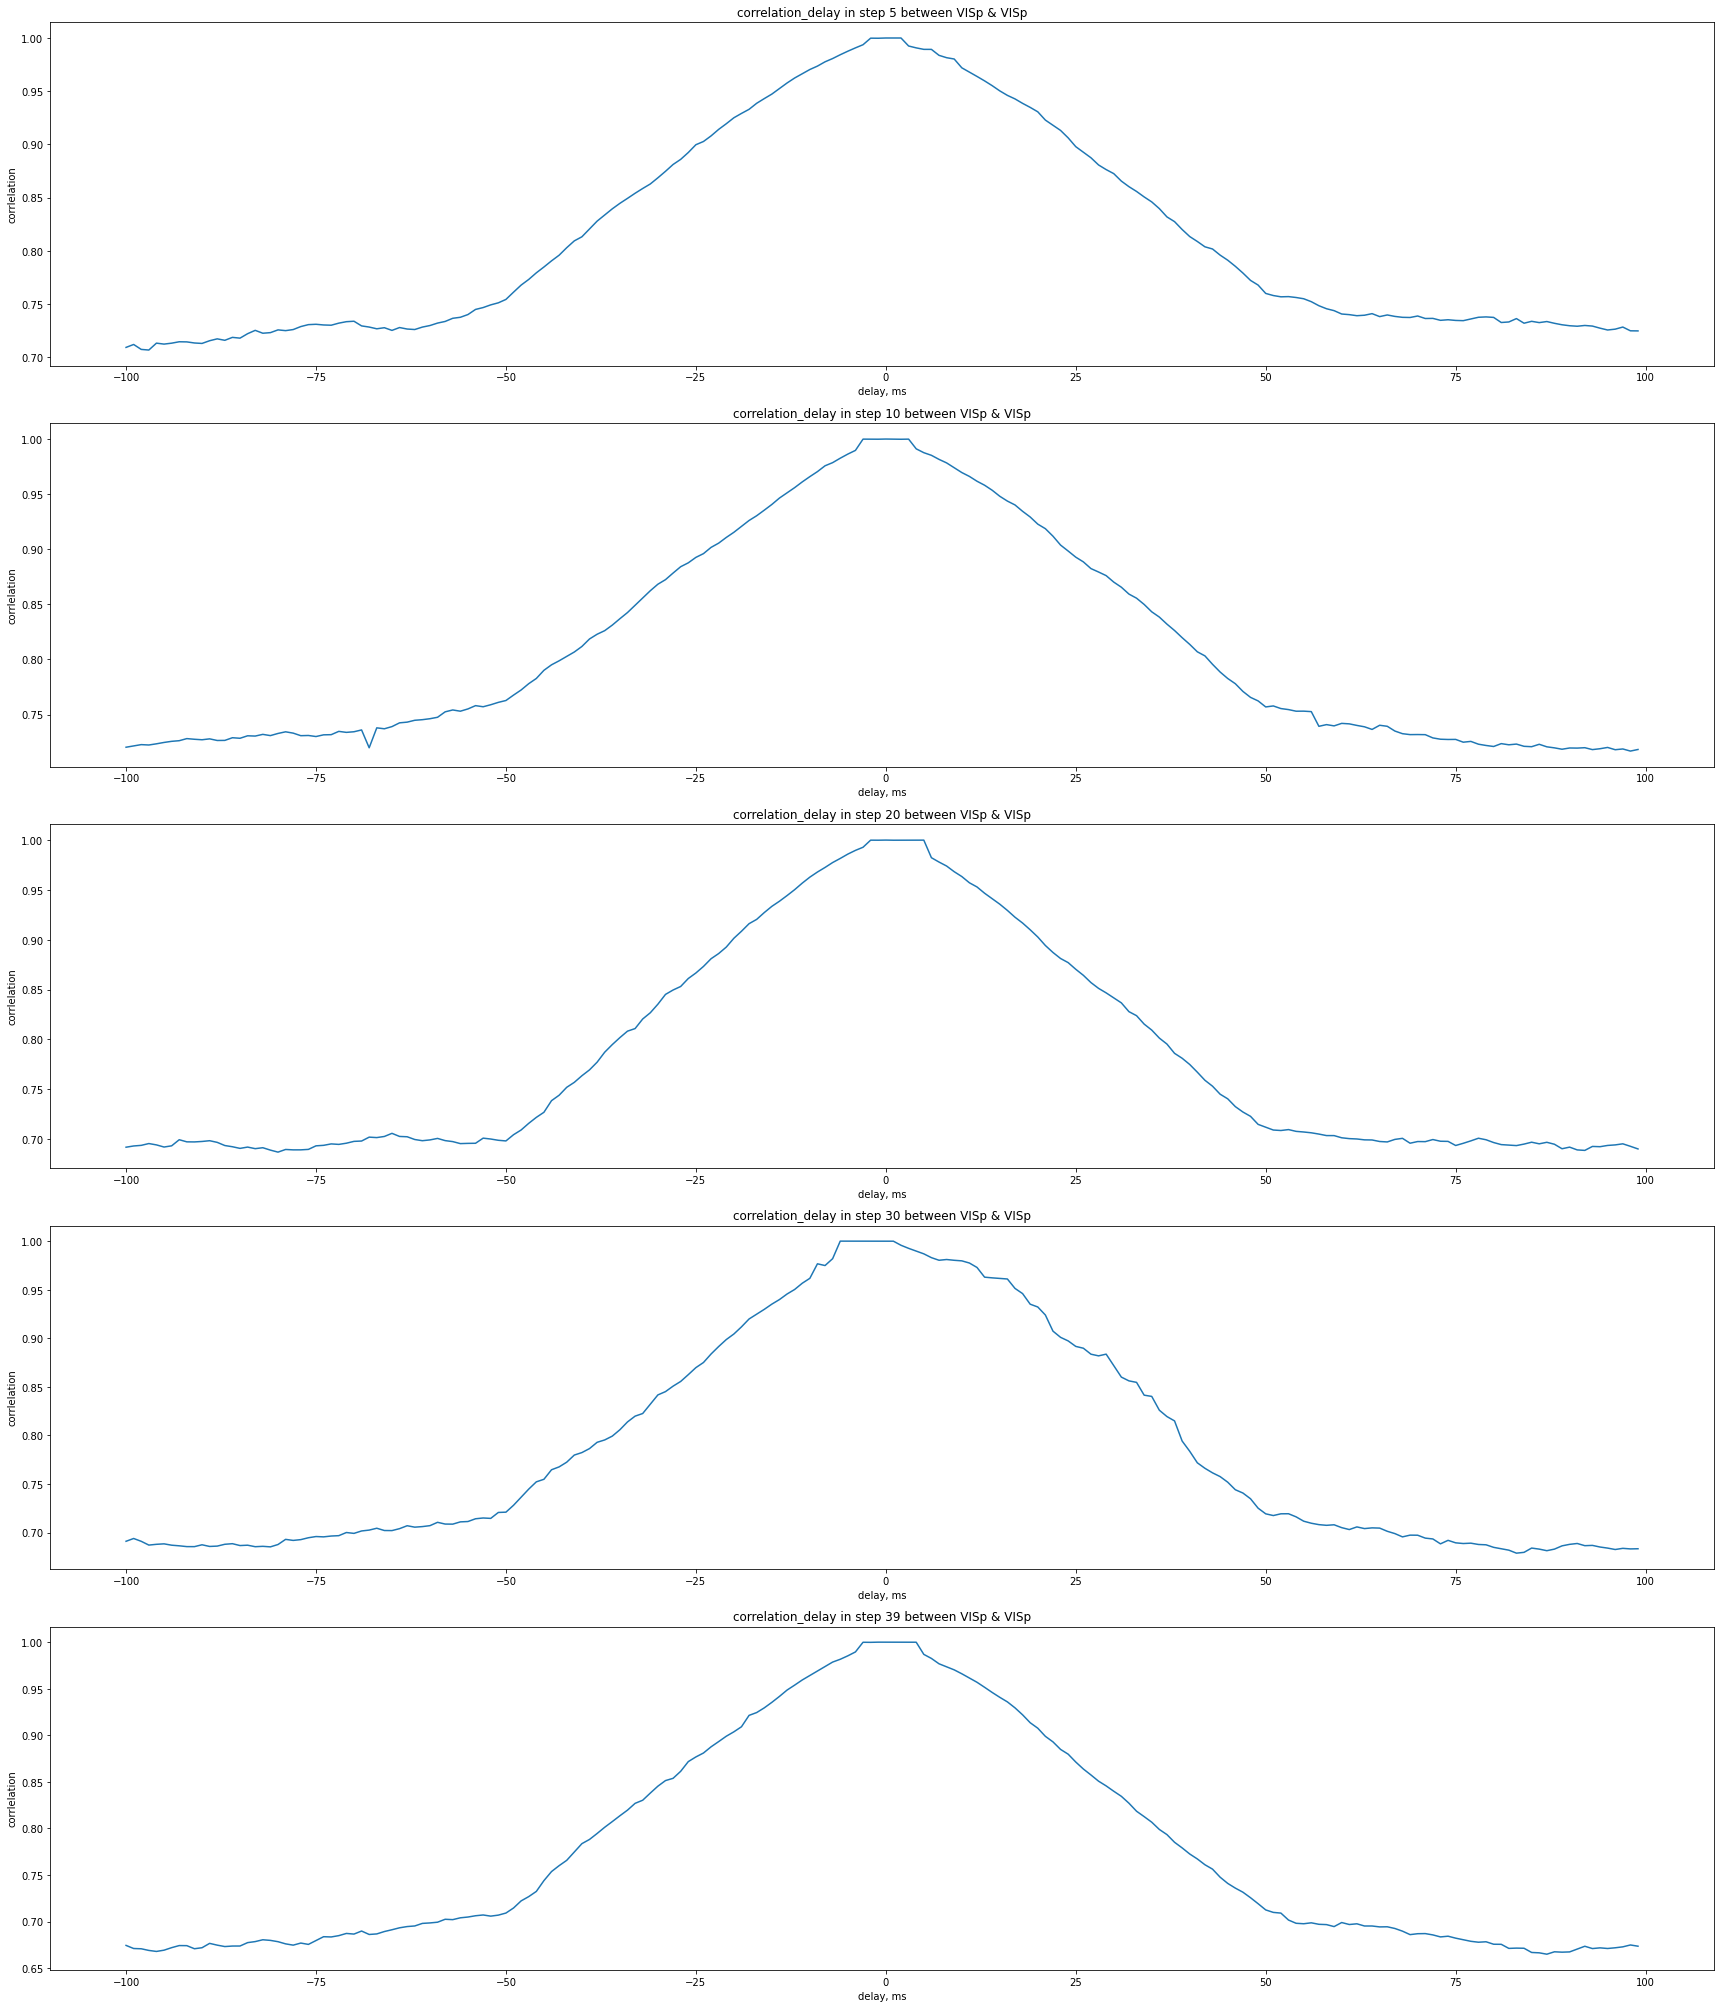

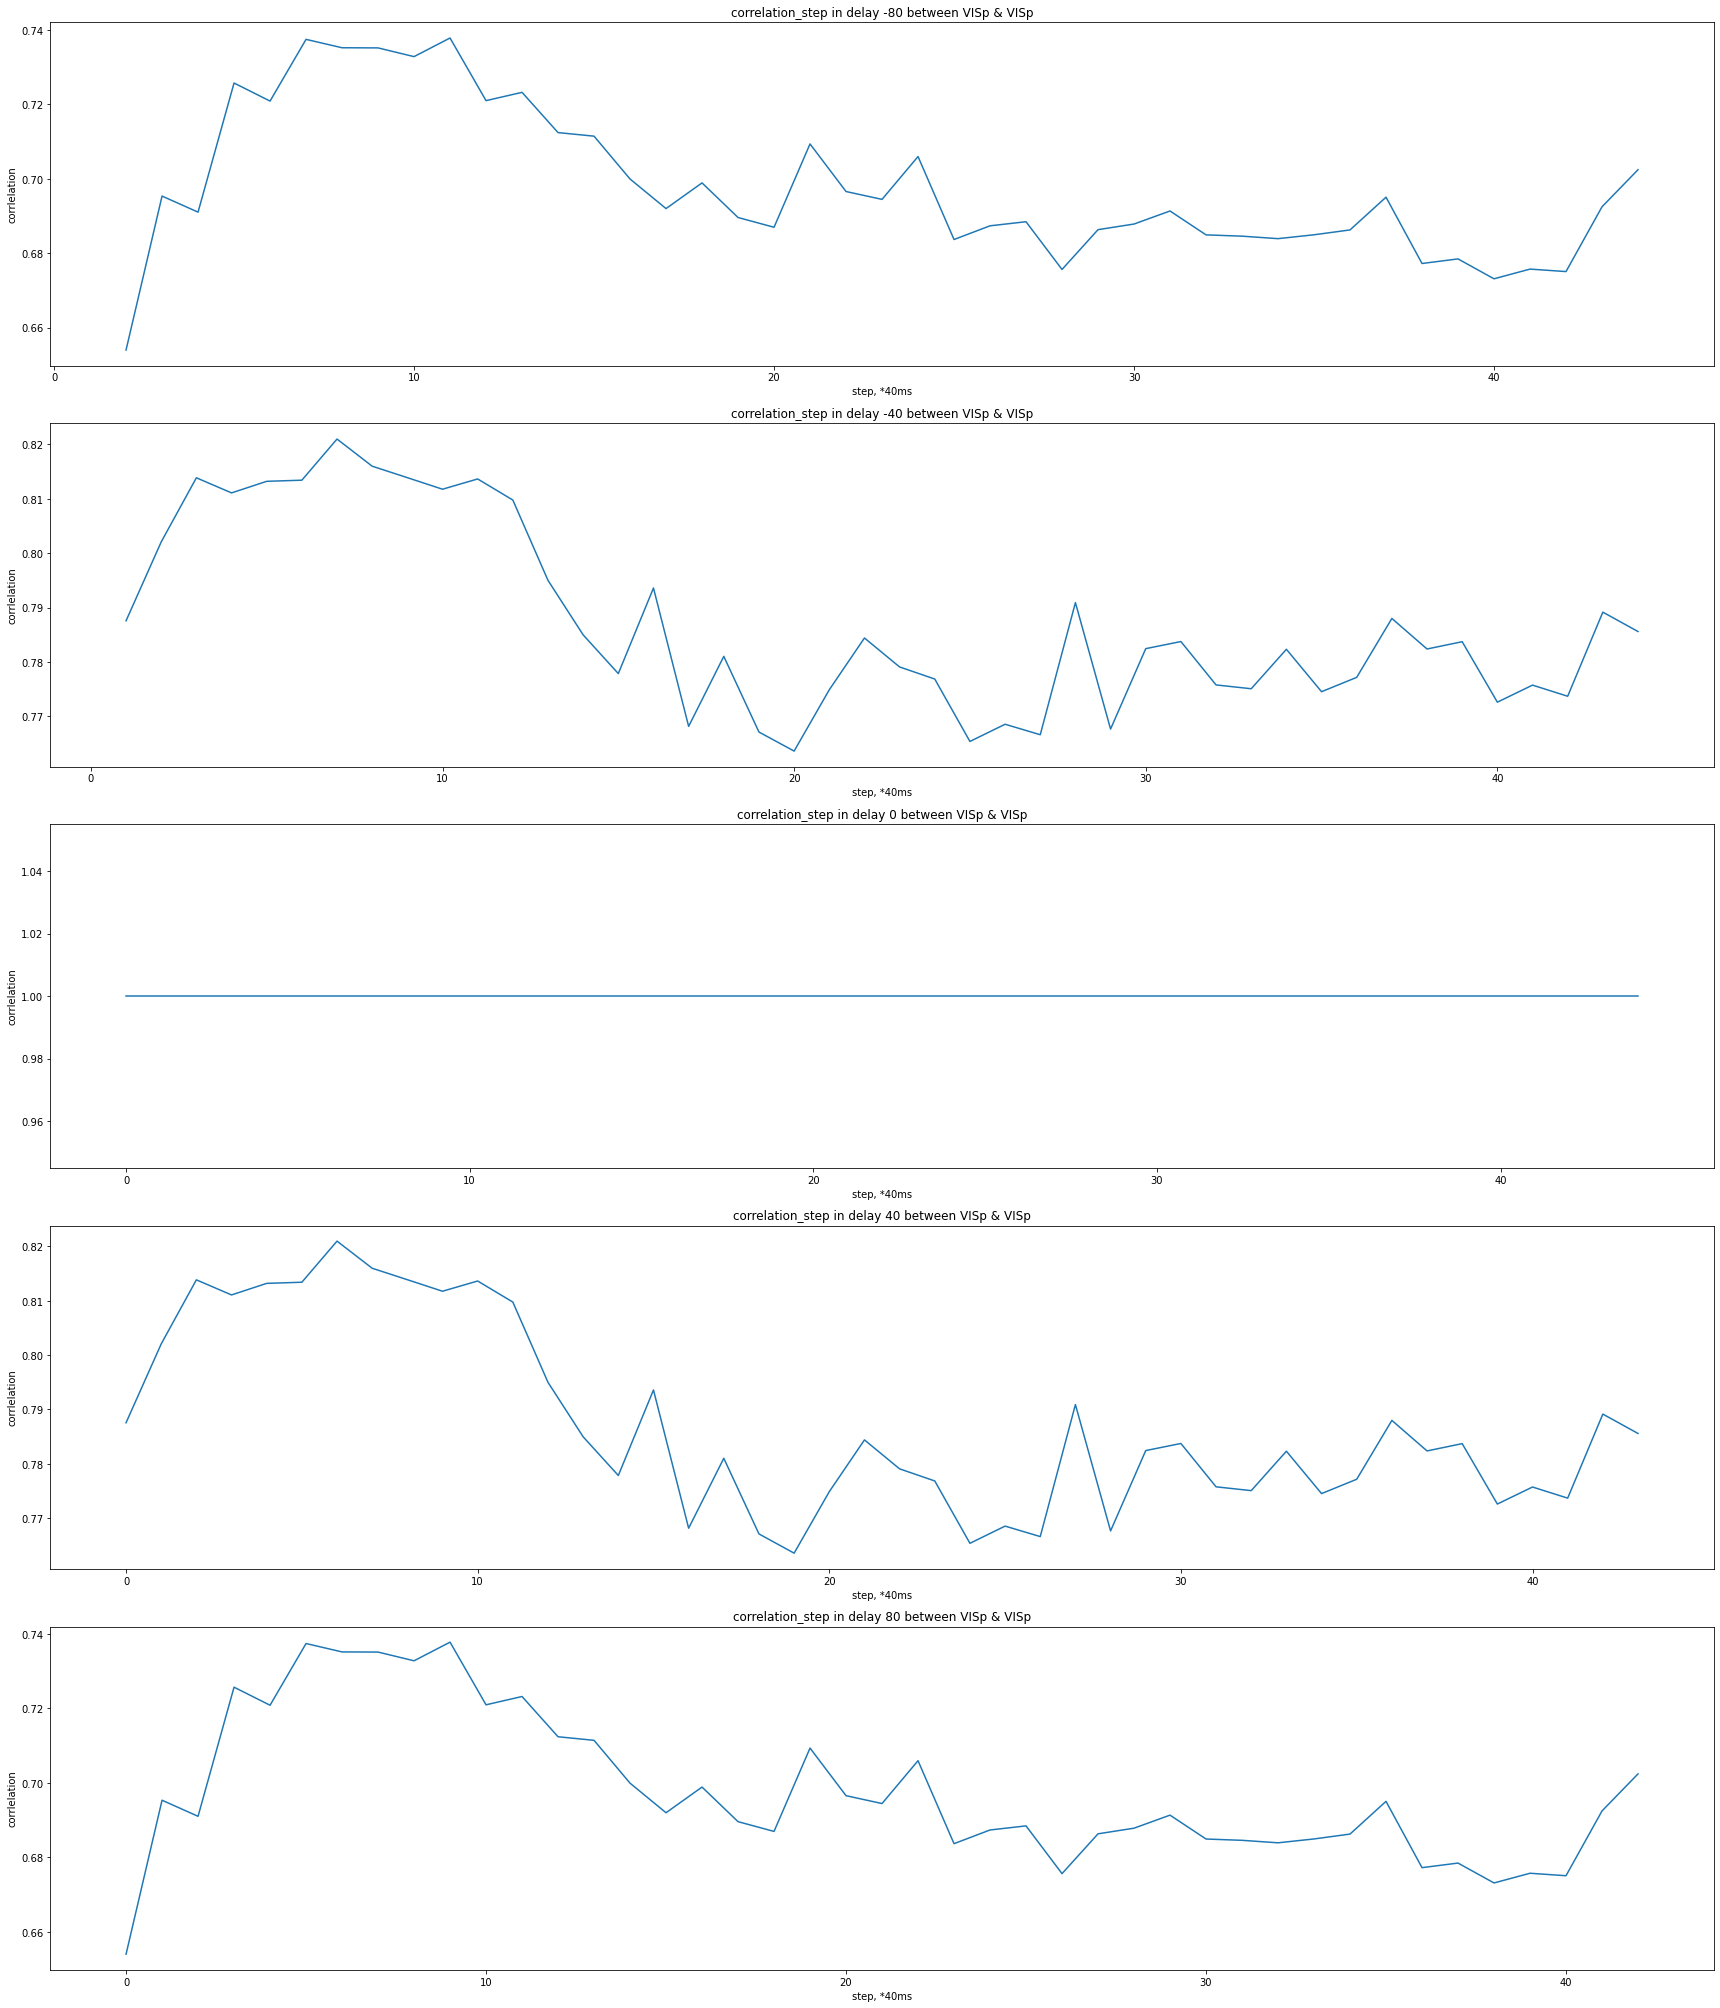

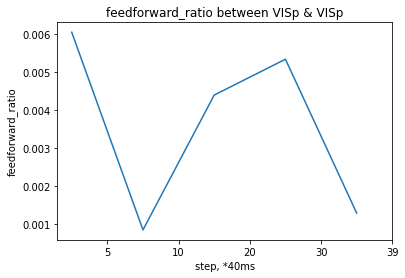

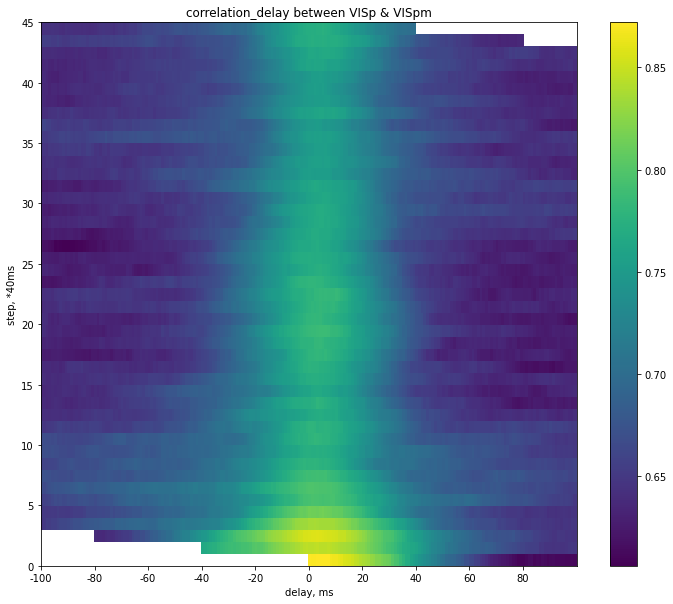

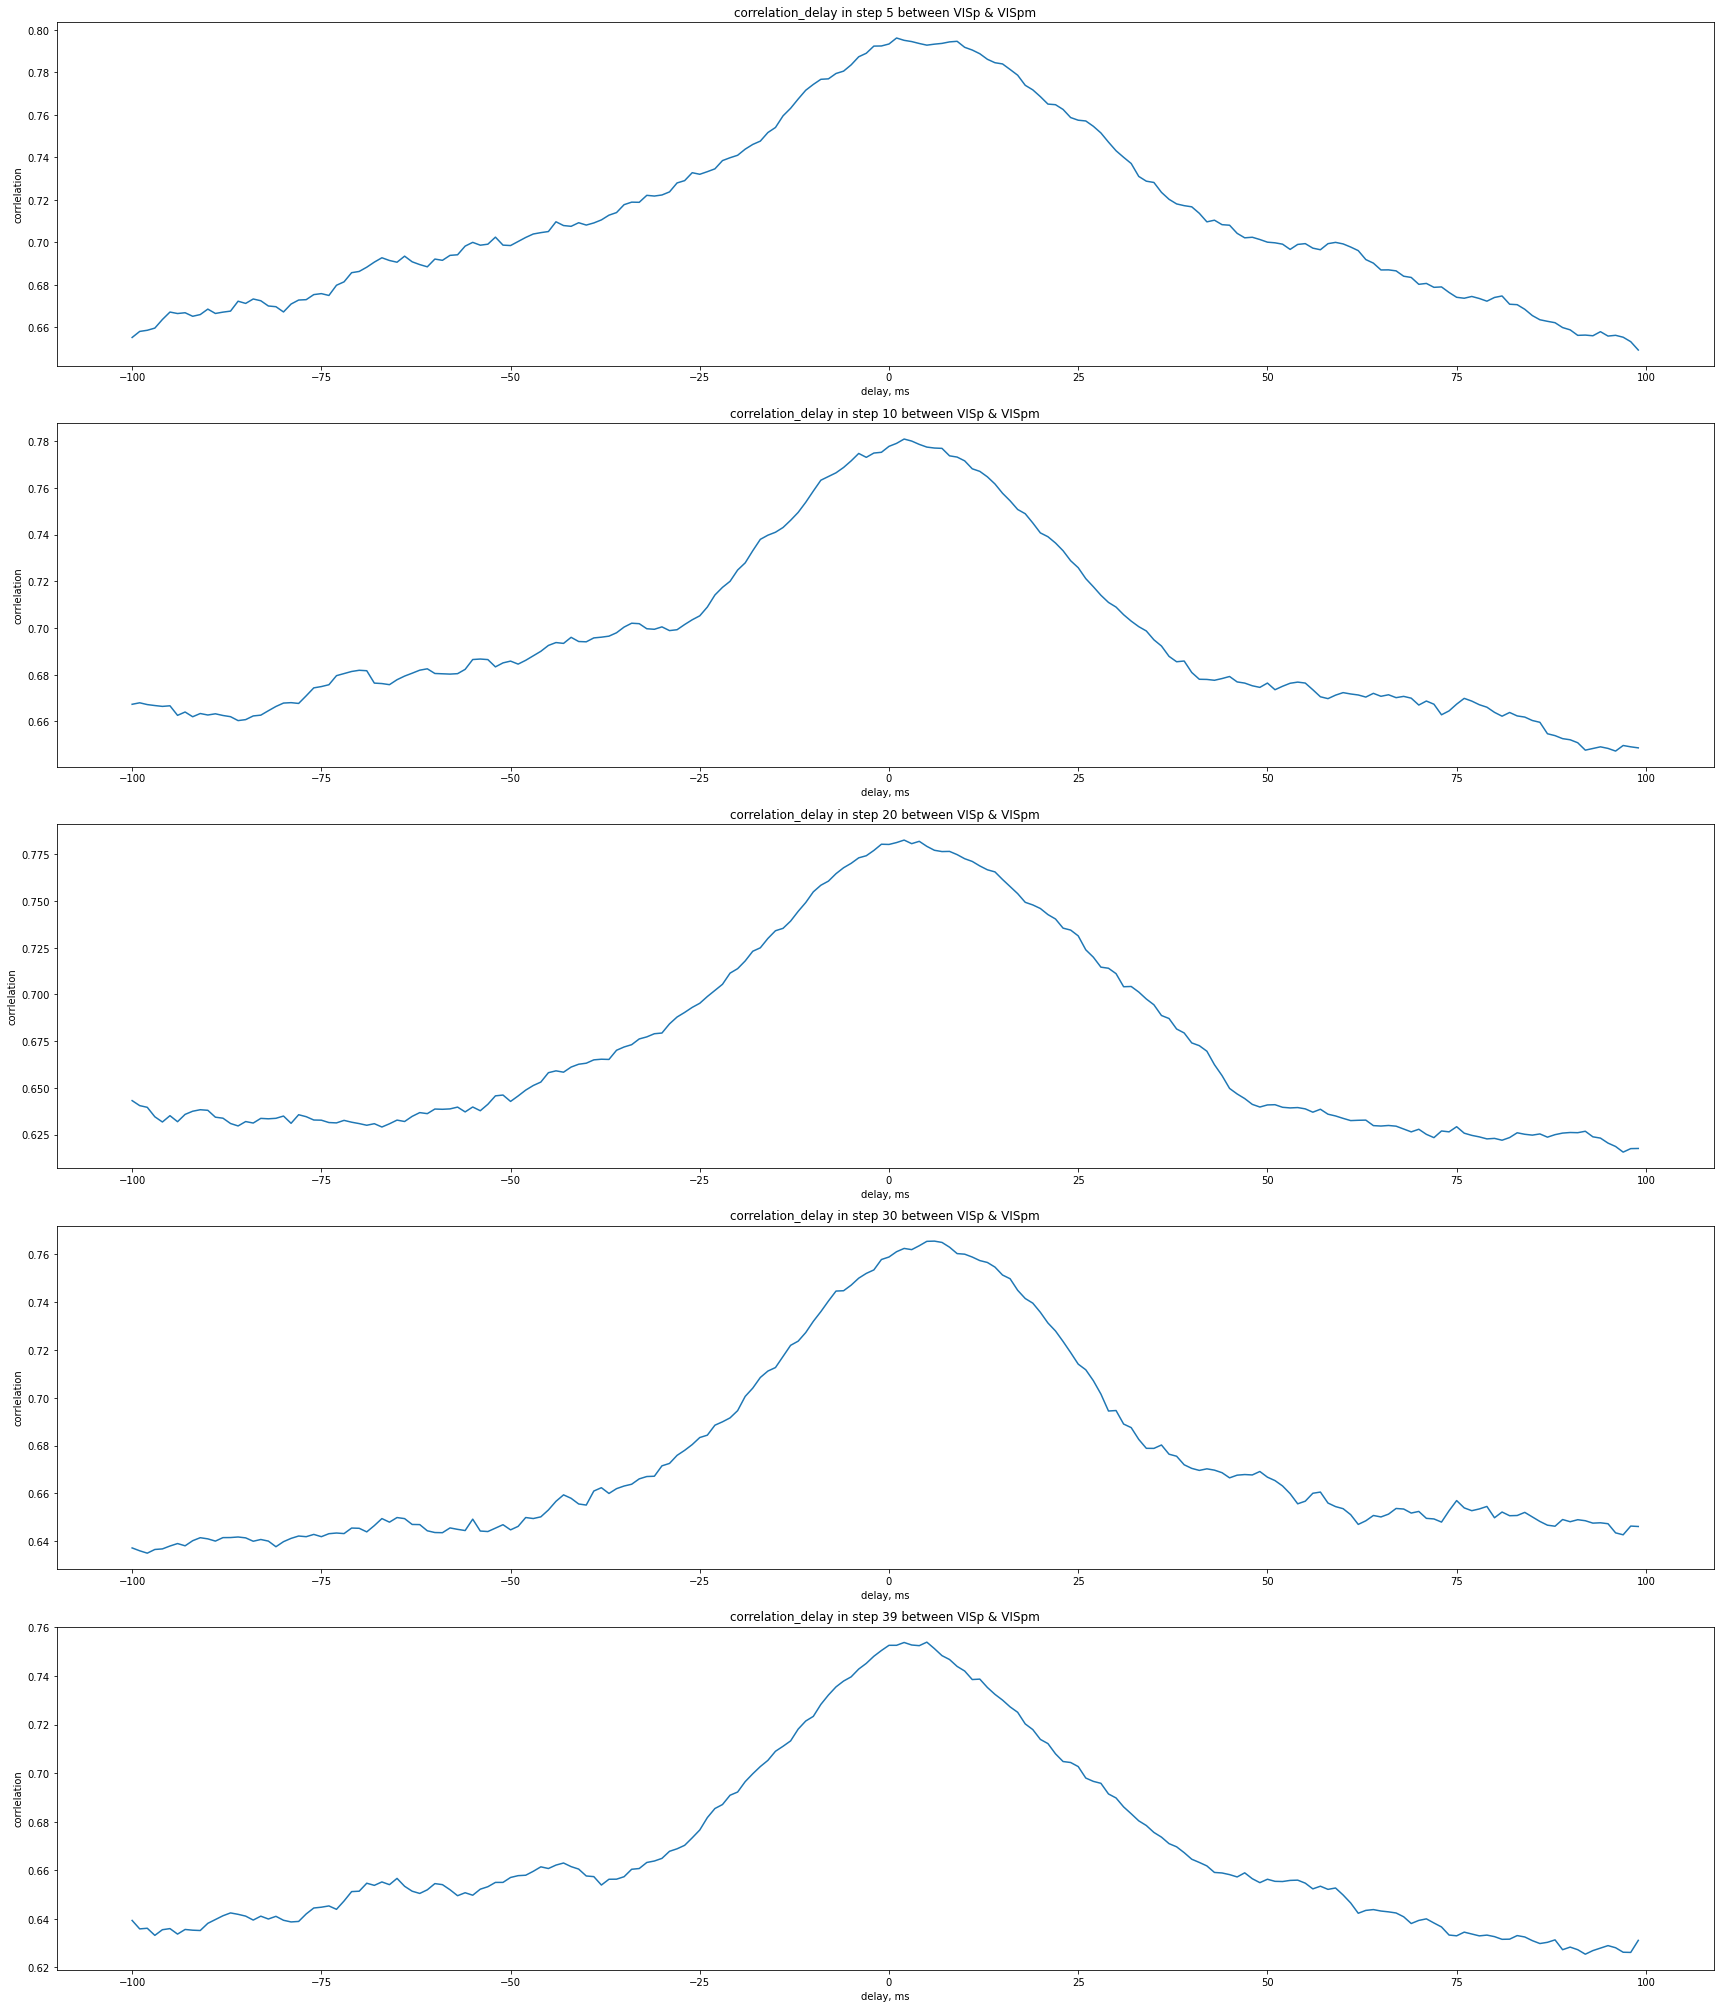

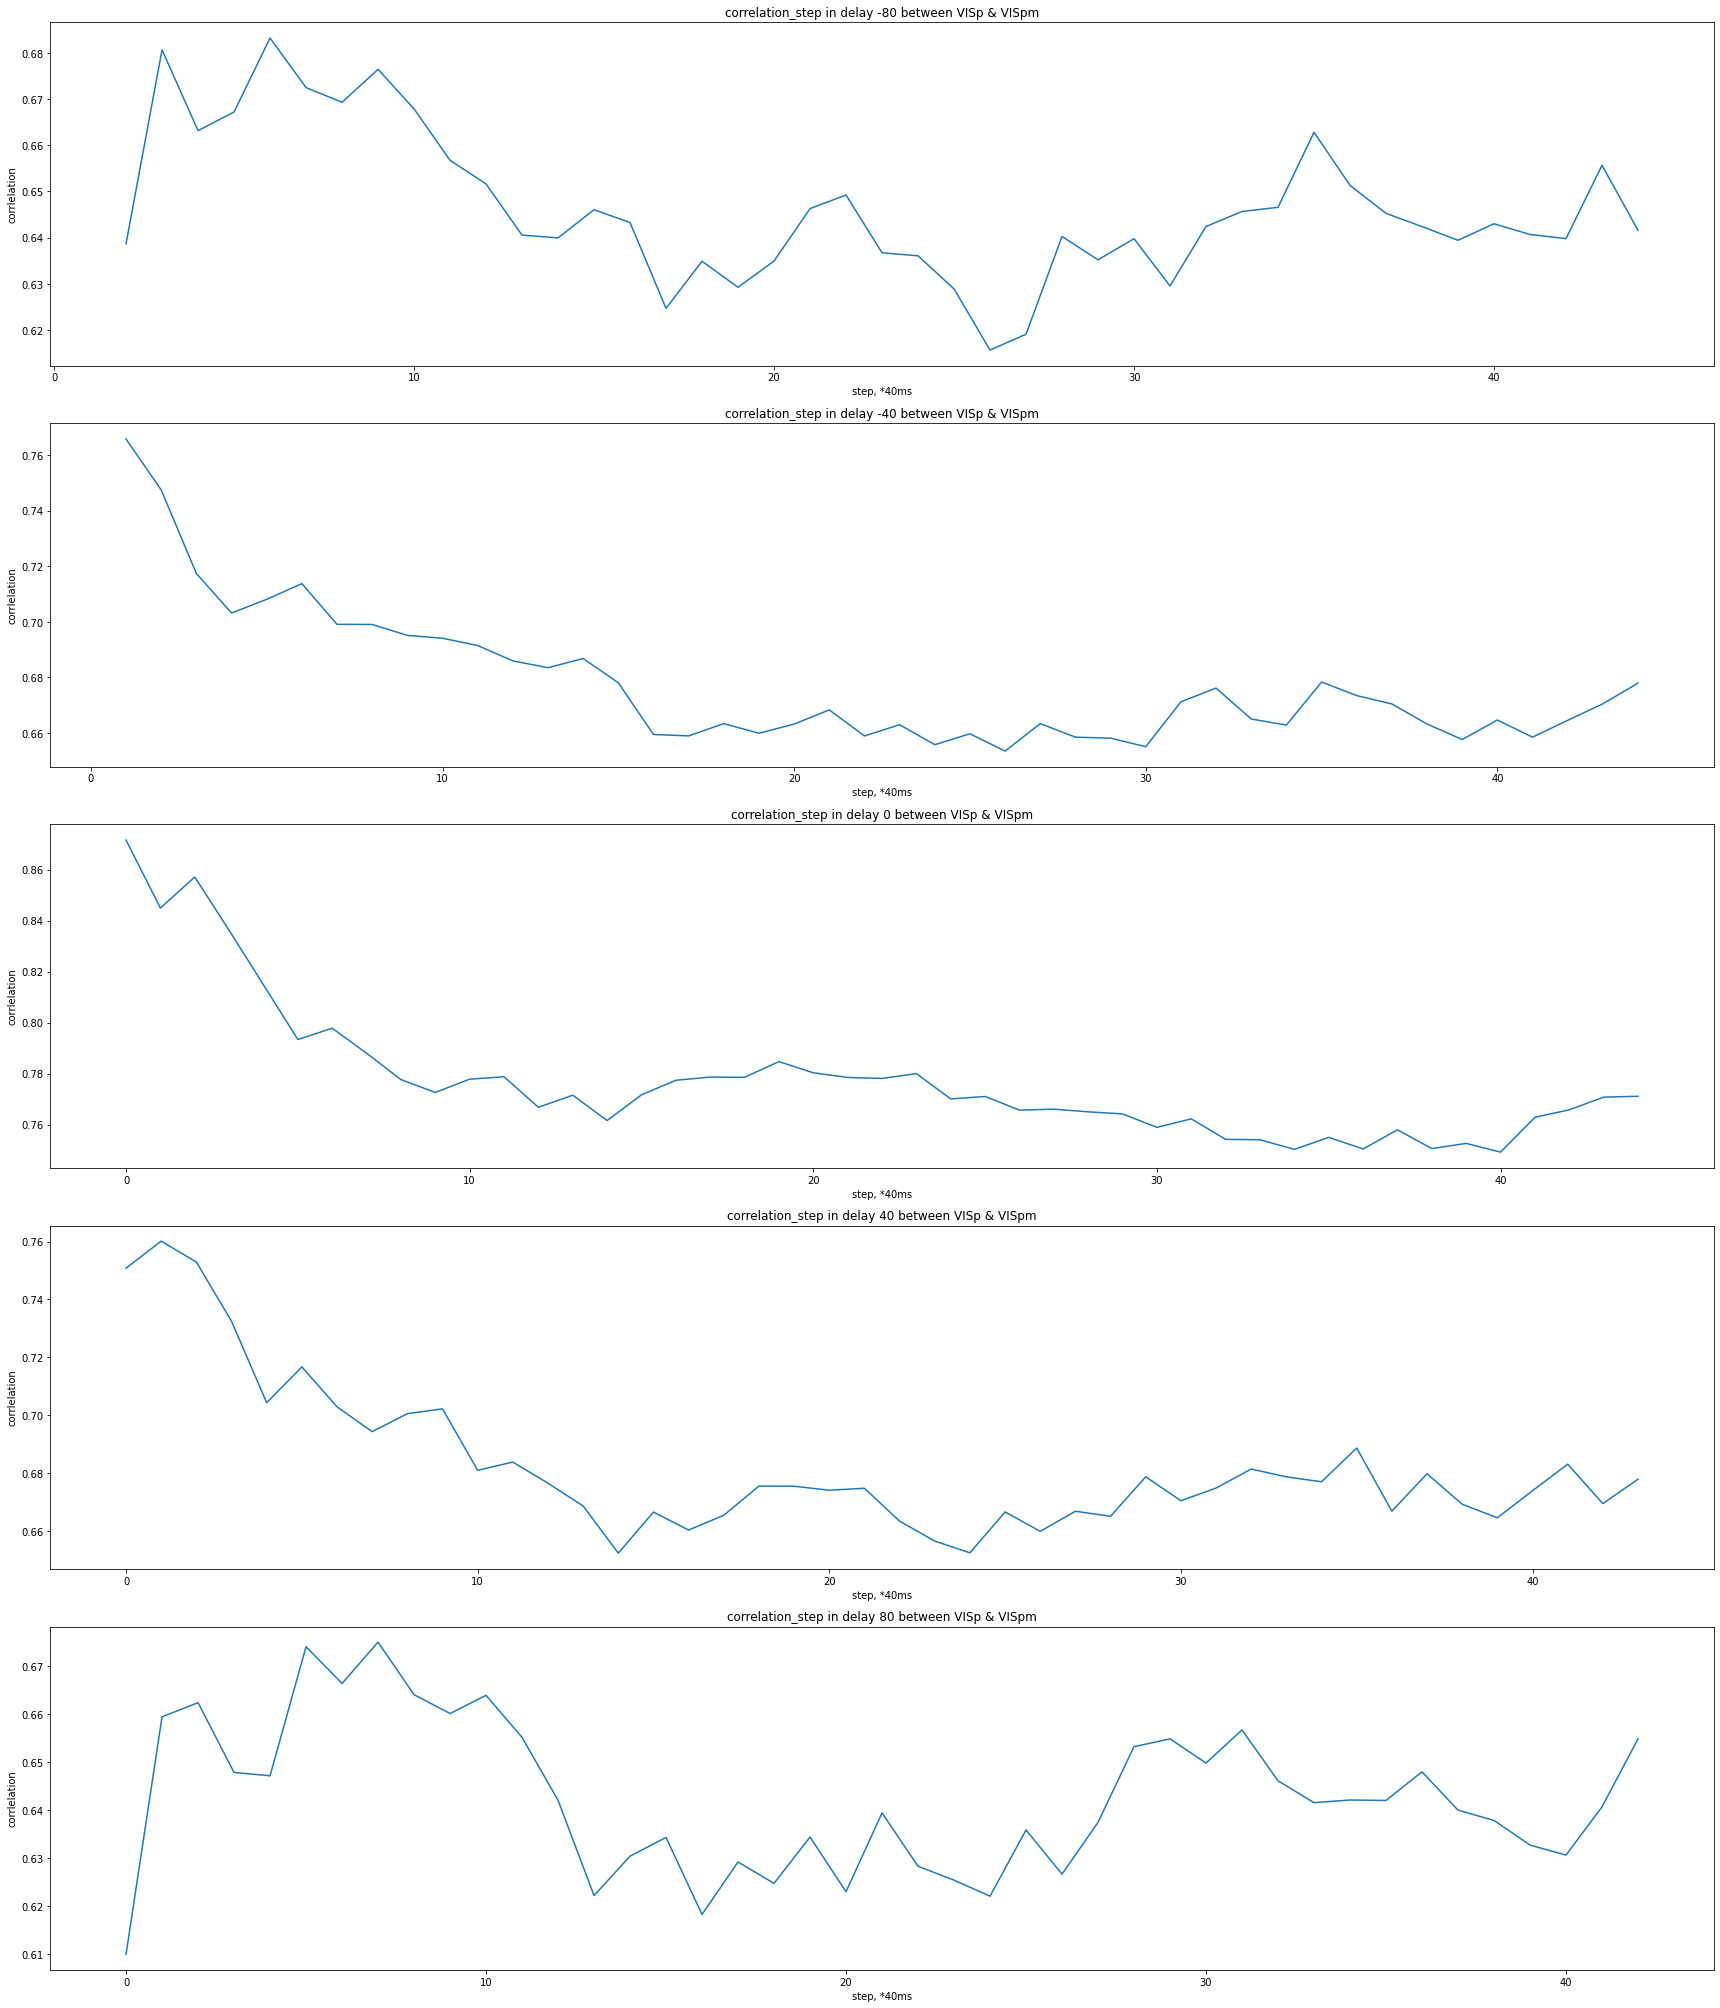

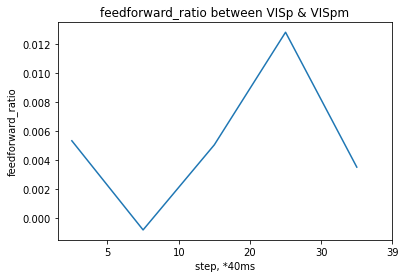

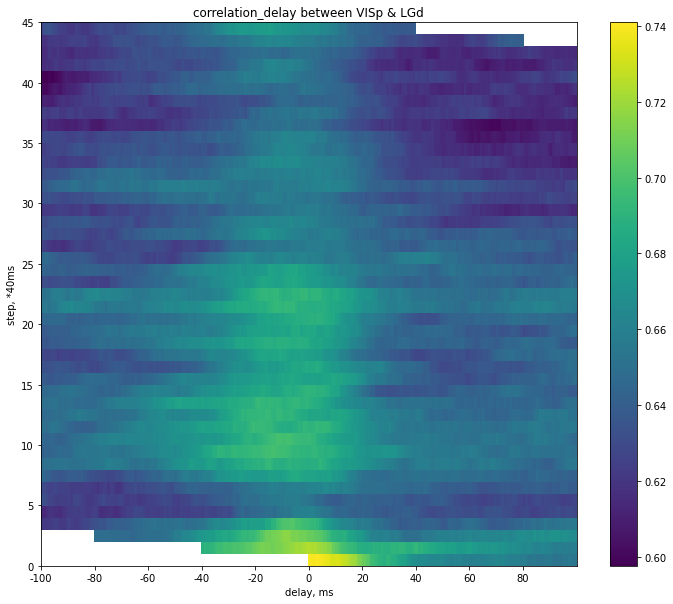

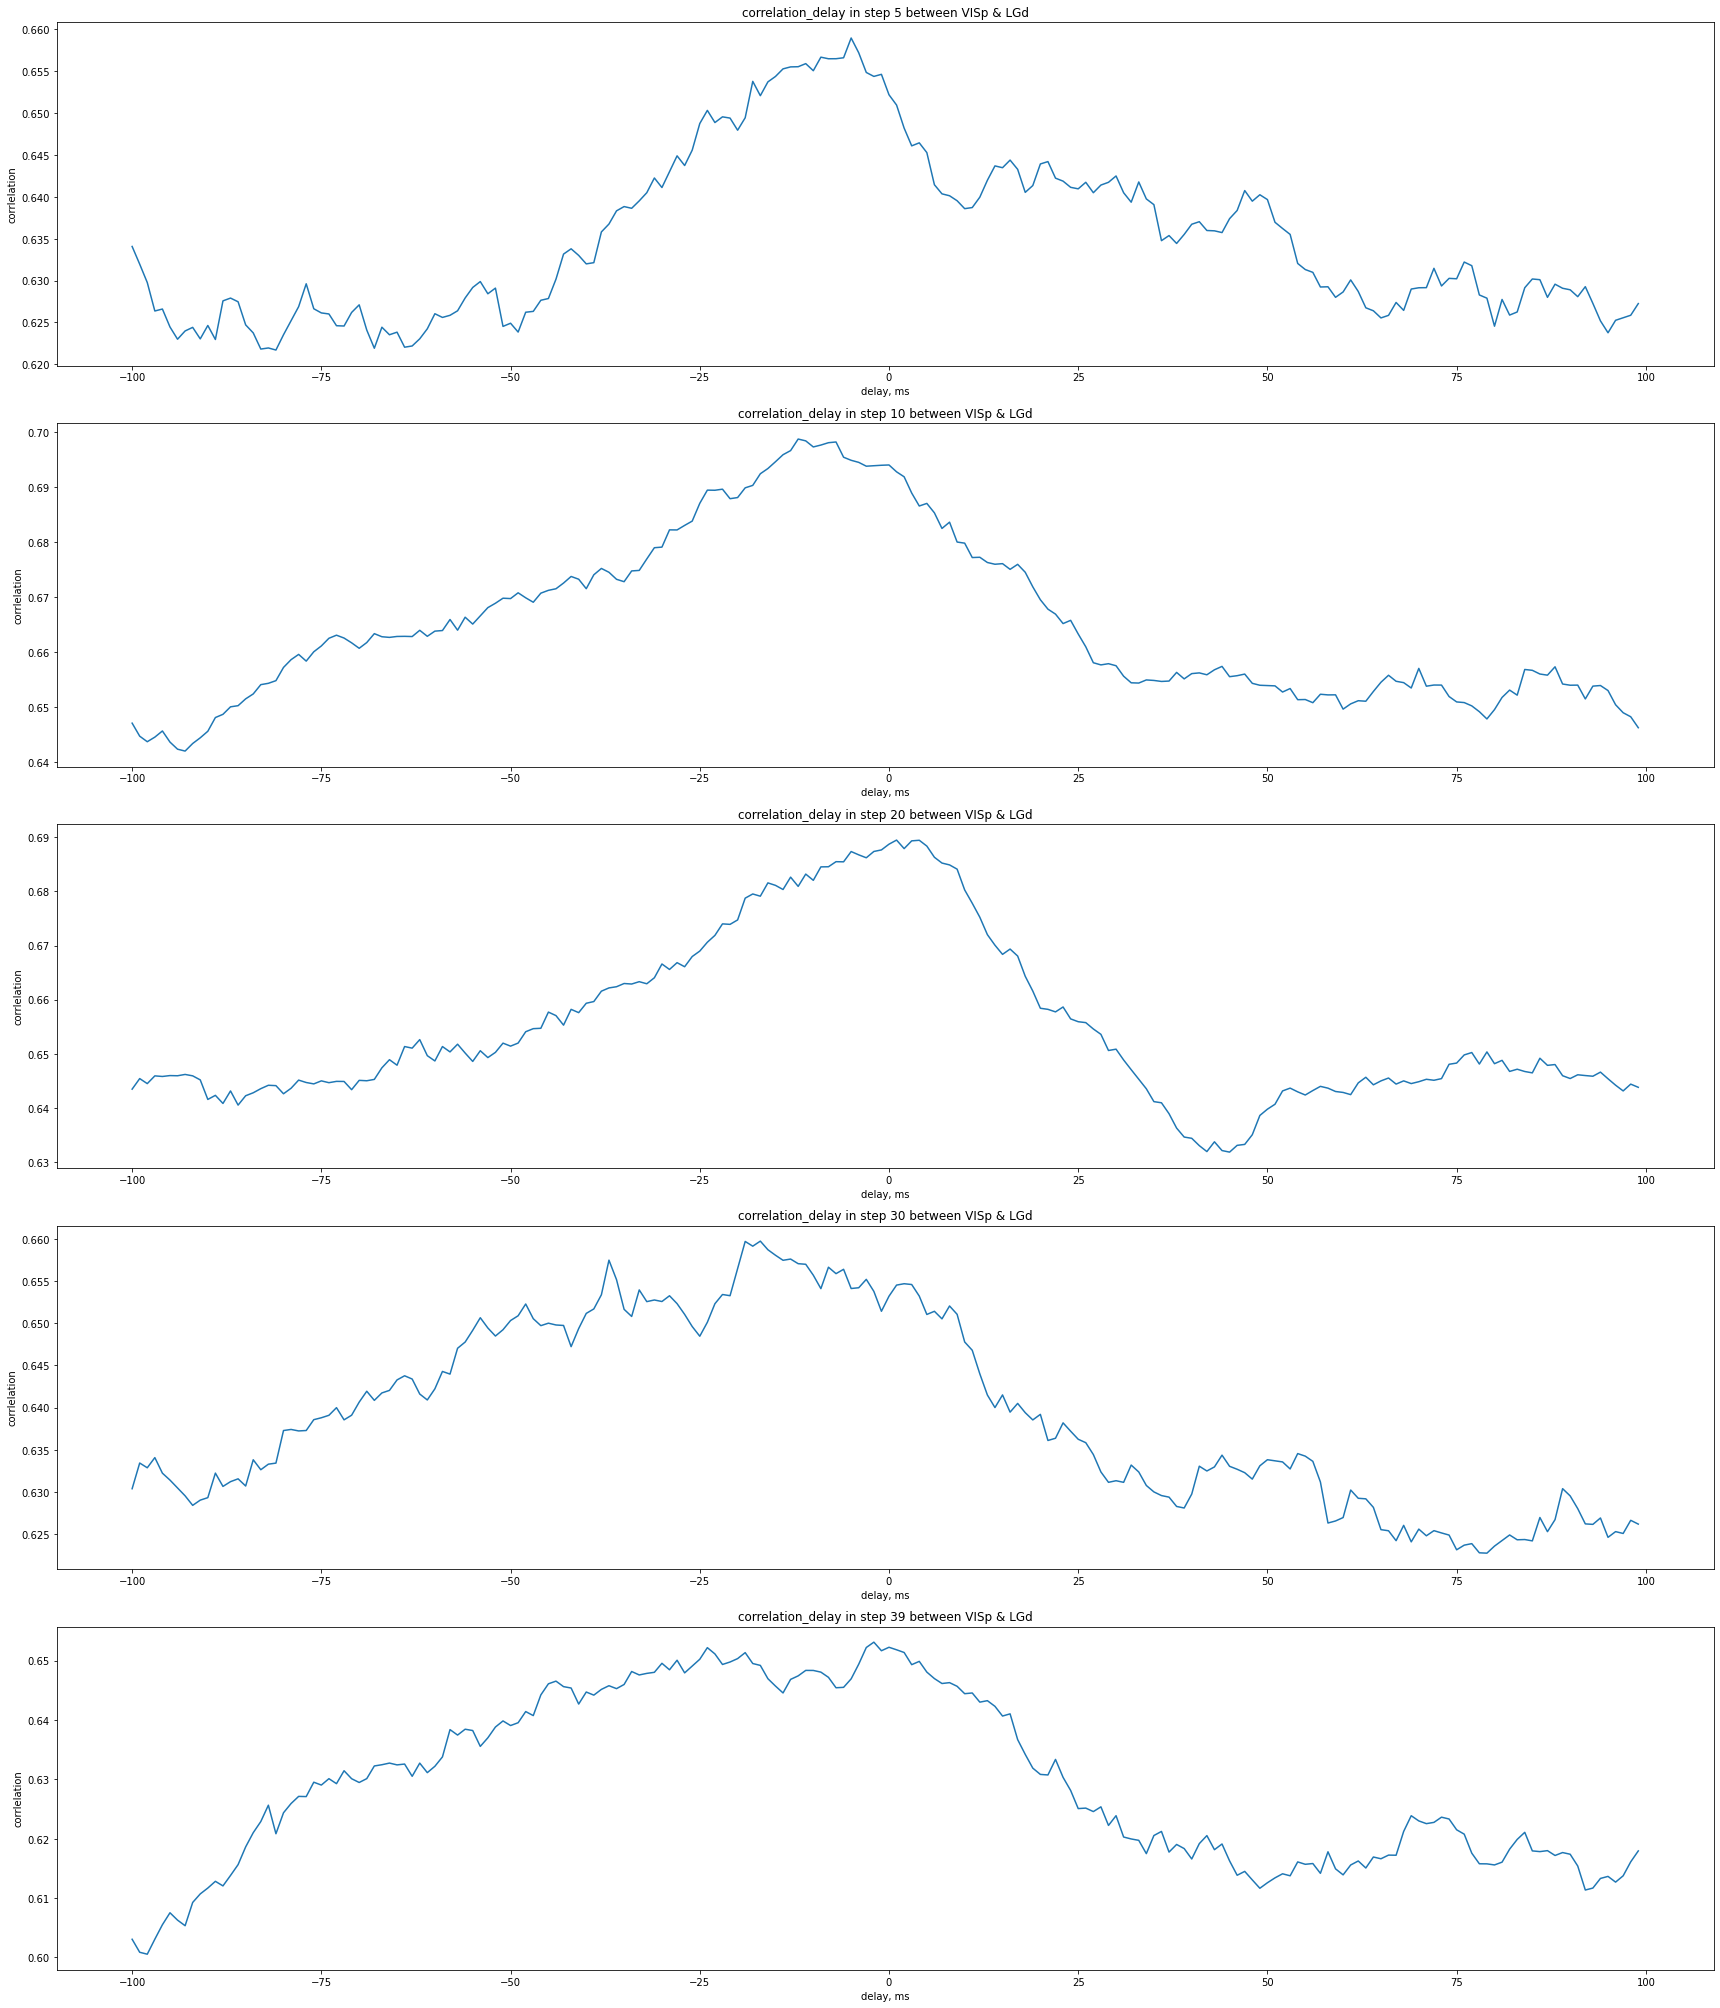

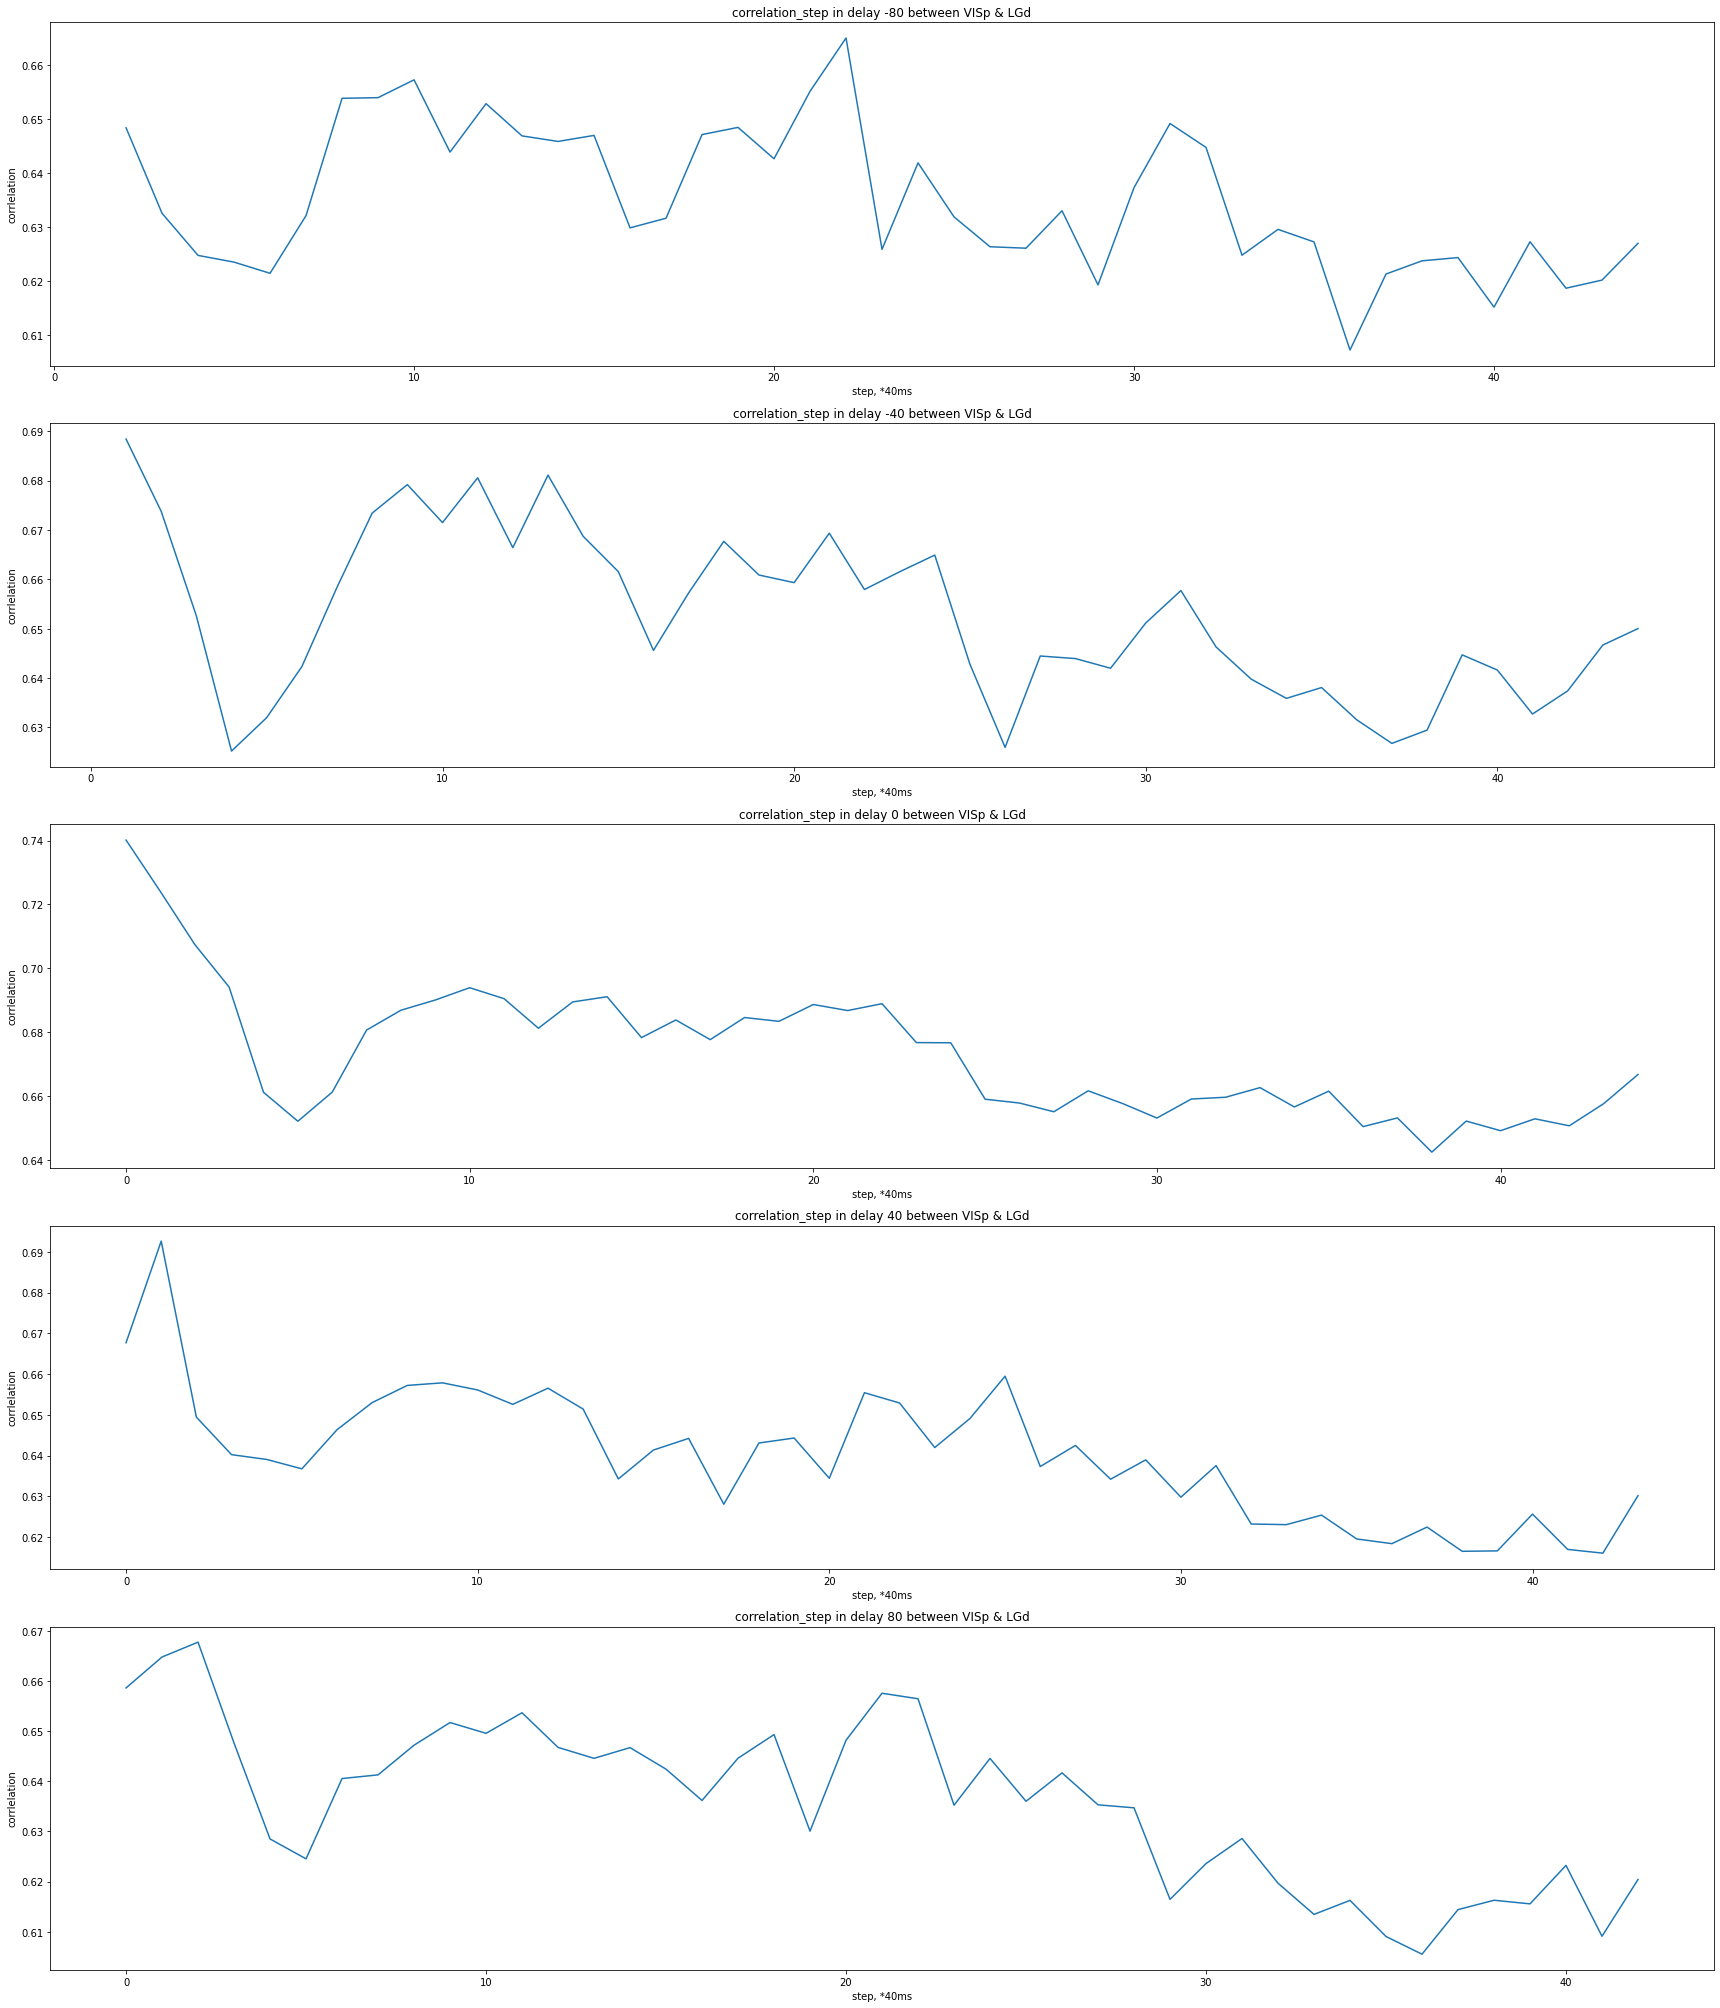

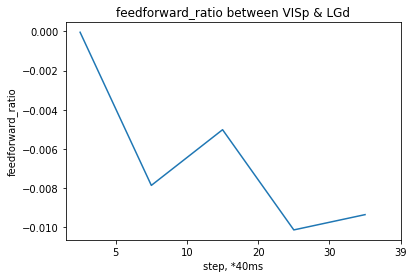

In [84]:
area_1 = 'VISp'
areas_2 = ['VISp', 'VISpm', 'LGd']
corr_delay_matrix_areas = {}    # save corr_delay_matrix every two areas

for i, area_2 in enumerate(areas_2):
    corr_matrix_delay = cca_delay_areas(area_1, area_2, stim_table=drift_stim_table)
    areas_key = area_1+'_'+area_2
    corr_delay_matrix_areas[areas_key] = corr_matrix_delay
    plot_corr_delay_matrix(corr_matrix_delay, area_1, area_2)
    plot_corr_delay(corr_matrix_delay, area_1, area_2)
    plot_corr_step(corr_matrix_delay, area_1, area_2)
    plot_feedforward_ratio(corr_matrix_delay, area_1, area_2)

### Task4 Hierarchy of information flow
* across areas, across sessions
* corr_delay_matrix acrtoss areas

In [8]:
def plot_corr_matrix_delay_areas(areas, corr_delay_matrix_areas):

    f, axes = plt.subplots(nrows=len(areas), ncols=len(areas), sharex=True, sharey=True, figsize=(24, 25))

    for i, area_1 in enumerate(areas):
        for j, area_2 in enumerate(areas):

            areas_key = area_1+'_'+area_2
            corr_matrix_delay = corr_delay_matrix_areas[areas_key]

            max_delay = int(corr_matrix_delay.shape[1]/2)
            axes[i, j].pcolormesh(corr_matrix_delay)

            if i == 0:
                axes[i, j].set_title(f'{area_2}')
            if j == len(areas)-1:
                axes[i, j].set_ylabel(f'{area_1}')
                axes[i, j].yaxis.set_label_position("right")
            if i == j:
                axes[i, j].set_xticks(range(0, corr_matrix_delay.shape[1], 20))
                axes[i, j].set_xticklabels(range(0, corr_matrix_delay.shape[1], 20)-np.array([max_delay]))

    f.suptitle('correlation_delay across areas')
    # f.colorbar(im)
    plt.tight_layout()
    plt.show

    return

In [10]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
corr_delay_matrix_areas = {}    # save corr_delay_matrix every two areas

for i, area_1 in enumerate(areas):
    for j, area_2 in enumerate(areas):
        corr_matrix_delay = cca_delay_areas(area_1, area_2, stim_table=drift_stim_table)
        areas_key = area_1+'_'+area_2
        corr_delay_matrix_areas[areas_key] = corr_matrix_delay

np.save('corr_delay_matrix_areas_755434585', corr_delay_matrix_areas)

plot_corr_matrix_delay_areas(areas, corr_delay_matrix_areas)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations 

* input/output dimensions

In [ ]:
def get_feedforward_ratio_areas(corr_delay_matrix_areas, step=5):

    feedforward_ratio_matrix = np.zeros((len(areas), len(areas)))
    feedforward_ratio_matrix_binary = np.zeros((len(areas), len(areas)))

    for i, area_1 in enumerate(areas):
        for j, area_2 in enumerate(areas):
            areas_key = area_1+'_'+area_2
            corr_matrix_delay = corr_delay_matrix_areas[areas_key]
            feedforward_ratio_matrix[i, j] = get_feedforward_ratio(corr_matrix_delay, step=step)
            if feedforward_ratio_matrix[i, j] > 0:
                feedforward_ratio_matrix_binary[i, j] = 1
            else:
                feedforward_ratio_matrix_binary[i, j] = -1

    return feedforward_ratio_matrix, feedforward_ratio_matrix_binary

def get_ff_fd_ratio(feedforward_ratio_matrix, areas):

    feedforward_num = np.zeros(len(areas))
    feedback_num = np.zeros(len(areas))
    ff_fd_ratio = np.zeros(len(areas))

    for i, area in enumerate(areas):
        feedforward_num[i] = len(np.where(feedforward_ratio_matrix[i, :]>0)[0])
        feedback_num[i] = len(np.where(feedforward_ratio_matrix[i, :]<0)[0])
        ff_fd_ratio[i] = (feedforward_num[i]-feedback_num[i])/(feedforward_num[i]+feedback_num[i])

    return feedforward_num, feedback_num, ff_fd_ratio


def plot_ff_ratio_matrix(feedforward_ratio_matrix, feedforward_ratio_matrix_binary, areas):

    fig, axes = plt.subplots(nrows=2, figsize=(12, 20))

    im_0 = axes[0].pcolormesh(feedforward_ratio_matrix)
    axes[0].set_xticks(range(len(areas))+np.array([0.5]))
    axes[0].set_xticklabels(areas)
    axes[0].set_yticks(range(len(areas))+np.array([0.5]))
    axes[0].set_yticklabels(areas)
    axes[0].set_title(f'feedforward_ratio_matrix')
    fig.colorbar(im_0, ax=axes[0])

    im_1 = axes[1].pcolormesh(feedforward_ratio_matrix_binary)
    axes[1].set_xticks(range(len(areas))+np.array([0.5]))
    axes[1].set_xticklabels(areas)
    axes[1].set_yticks(range(len(areas))+np.array([0.5]))
    axes[1].set_yticklabels(areas)
    axes[1].set_title(f'feedforward_ratio_matrix_binary')
    fig.colorbar(im_1, ax=axes[1])

    plt.show()

    return

def plot_ff_ratio_changing(feedforward_ratio_matrix, areas):

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 28), sharex=True)

    for i, area in enumerate(areas):
        
        axes[i].plot(np.array(range(len(areas))), feedforward_ratio_matrix[i, :])
        axes[i].hlines(y=0, xmin=0, xmax=len(areas), colors = "r", linestyles = "dashed")
        axes[i].bar(np.array(range(len(areas))), feedforward_ratio_matrix[i, :], width=0.6, tick_label=areas, fc='c')
        axes[i].set_ylabel(f'{area}')

    f.suptitle('ff_ratio across areas')
    plt.tight_layout()
    plt.show()

    return

def plot_ff_fd(feedforward_num, feedback_num, areas):

    plt.figure(figsize=(24, 12))
    
    x = np.array(range(len(areas)))
    width=0.4
    plt.bar(x, feedforward_num, width=width, label='feedforward_num', fc='c')
    plt.bar(x+np.array([width]), feedback_num, width=width, label='feedback_num', tick_label=areas, fc='r')
    plt.legend()

    # show num on the bar
    for a, b in zip(x, feedforward_num):
        plt.text(a, b, b, ha='center', va='bottom')
    for a, b in zip(x+width, feedback_num):
        plt.text(a, b, b, ha='center', va='bottom')

    plt.title(f'feedforward & feedback nums of different areas')
    plt.show()
    return

def plot_ff_fd_ratio(ff_fd_ratio, areas):

    f, ax = plt.subplots(figsize=(24, 10))

    ax.plot(np.array(range(len(areas))), ff_fd_ratio)
    ax.bar(np.array(range(len(areas))), ff_fd_ratio, width=0.6, tick_label=areas, fc='c')
    ax.set_ylabel(f'ff_fd_ratio')
    f.suptitle('ff_fd_ratio across areas')

    plt.show()

    return

In [ ]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

feedforward_ratio_matrix, feedforward_ratio_matrix_binary = get_feedforward_ratio_areas(corr_delay_matrix_areas)

print(feedforward_ratio_matrix)
plot_ff_ratio_matrix(feedforward_ratio_matrix, feedforward_ratio_matrix_binary, areas)
plot_ff_ratio_changing(feedforward_ratio_matrix, areas)

feedforward_num, feedback_num, ff_fd_ratio = get_ff_fd_ratio(feedforward_ratio_matrix, areas)

plot_ff_fd(feedforward_num, feedback_num, areas)
plot_ff_fd_ratio(ff_fd_ratio, areas)

### Task5 Dimensionity of subspaces intra-areas and inter-areas

* intra dimensionity got by FA

In [ ]:
def cross_val_FA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)


        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def intra_dim_FA(des_mat):
    
    N, n_features = des_mat.shape

    # # select proper latent dimensions from [1, p-1]
    # cv_log_like = np.zeros(n_features-1)
    # for i in range(n_features-1):
    #     latent_dim = i + 1
    #     cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    # latent_dim_log_like = np.argmax(cv_log_like) + 1

    # select proper latent dimensions from [1, p-1]
    if n_features > 20:
        # as n_features is more, cv_log_like is more
        # so to save time, limit 20 possible dim to try
        start_feature = n_features - 20
        cv_log_like = np.zeros(20)
        features = range(n_features)[start_feature:]
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)     
    else:
        cv_log_like = np.zeros(n_features-1)
        features = range(n_features-1) + 1
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = features[np.argmax(cv_log_like) + 1]

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)

    eigvals, eigvecs = np.linalg.eig(load_mat.T @ load_mat)
    ind = np.argsort(-eigvals)
    eigvals = eigvals[ind]
    shared_var = np.cumsum(eigvals)/np.sum(eigvals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]

    return latent_dim


def get_intra_dim_area(areas, stim_table):

    intra_dim_area = np.zeros(len(areas))

    for i, area in enumerate(areas):
        des_mat = get_design_matrix(area, stim_table)
        intra_dim_area[i] = intra_dim_FA(des_mat)

    print('intra_dim_area', intra_dim_area)

    return intra_dim_area

def plot_intra_dim_areas(areas, units_area, intra_dim_area):

    # intra_dimension for all areas
    x = np.array(range(len(areas)))
    width=0.4
    plt.figure(figsize=(16, 10))
    plt.bar(x, units_area, width=width, label='units',fc='y')
    plt.bar(x+np.array([width]), intra_dim_area, width=width, label='intra_dimensions', tick_label=areas, fc='r')
    plt.legend()

    # show num on the bar
    for a, b in zip(x, units_area):
        plt.text(a, b, b, ha='center', va='bottom')
    for a, b in zip(x+width, intra_dim_area):
        plt.text(a, b, b, ha='center', va='bottom')

    plt.title(f'intra_dim & units in different areas')
    plt.show()

    return

In [ ]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

units_area = get_units_area(areas, session)
intra_dim_area = get_intra_dim_area(areas, stim_table=drift_stim_table)
np.save('intra_dim_area_755434585', intra_dim_area)

plot_intra_dim_areas(areas, units_area, intra_dim_area)

* inter dimensionity got by pCCA

In [ ]:
def cross_val_pCCA(des_mat, latent_dim):

    k_fold = 10
    kf = KFold(n_splits=k_fold)
    log_like = np.zeros(k_fold)

    fold = 0
    for train_index, test_index in kf.split(des_mat):
        train, test = des_mat[train_index], des_mat[test_index]
        # print("TRAIN:", train.shape, "TEST:", test.shape)

        fa = FactorAnalysis(n_components=latent_dim)
        fa.fit(train)

        log_like[fold] = fa.score(test)   # get Average log-likelihood of test
        fold = fold + 1

    return log_like.mean()

def inter_dim_pCCA(des_mat_1, des_mat_2):
    
    des_mat = np.concatenate((des_mat_1, des_mat_2), axis = 1)

    N, n_features = des_mat.shape
    _, n_features_1 = des_mat_1.shape
    _, n_features_2 = des_mat_2.shape

    # # select proper latent dimensions from [1, n_features-1]
    # cv_log_like = np.zeros(n_features-1)
    # for i in range(n_features-1):
    #     latent_dim = i + 1
    #     cv_log_like[i] = cross_val_pCCA(des_mat, latent_dim)

    # latent_dim_log_like = np.argmax(cv_log_like) + 1
    # print('latent_dim_log_like', latent_dim_log_like)

    # select proper latent dimensions from [1, p-1]
    if n_features > 20:
        # as n_features is more, cv_log_like is more
        # so to save time, limit 20 possible dim to try
        start_feature = n_features - 20
        cv_log_like = np.zeros(20)
        features = range(n_features)[start_feature:]
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)     
    else:
        cv_log_like = np.zeros(n_features-1)
        features = range(n_features-1) + 1
        for i, fea in enumerate(features):
            latent_dim = fea
            cv_log_like[i] = cross_val_FA(des_mat, latent_dim)

    latent_dim_log_like = features[np.argmax(cv_log_like) + 1]

    # select proper latent dimensions with best dim got by log_like
    fa = FactorAnalysis(n_components=latent_dim_log_like)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    _, sing_vals, _ = np.linalg.svd(load_mat_1.T @ load_mat_2)

    shared_var = np.cumsum(sing_vals)/np.sum(sing_vals)

    threshold = 0.9
    latent_dim = np.where(shared_var>threshold)[0][0]
    print('latent_dim', latent_dim)

    # use the proper latent_dim to fit
    fa = FactorAnalysis(n_components=latent_dim)
    fa.fit(des_mat)
    load_mat = fa.components_   # (n_components, n_features)
    load_mat_1 = load_mat[:, :n_features_1]
    load_mat_2 = load_mat[:, n_features_1:]

    return latent_dim, (load_mat_1, load_mat_2)

def get_inter_dim_area(areas, stim_table):

    inter_dim_areas = np.zeros([len(areas), len(areas)])
    pCCA_load_mat_1 = {}
    pCCA_load_mat_2 = {}

    for i, area_1 in enumerate(areas):
        des_mat_1 = get_design_matrix(area_1, stim_table)
        for j, area_2 in enumerate(areas):
            name = f'area_1' + '_' + f'area_2'
            des_mat_2 = get_design_matrix(area_2, stim_table)
            inter_dim_areas[i, j], (pCCA_load_mat_1[name], pCCA_load_mat_2[name]) = inter_dim_pCCA(des_mat_1, des_mat_2)
            
    # print('inter_dim_areas', inter_dim_areas)

    return inter_dim_areas, pCCA_load_mat_1, pCCA_load_mat_2

def plot_inter_dim_areas(areas, intra_dim_area, inter_dim_areas):
    # inter_dimension across every two areas

    f, axes = plt.subplots(nrows=len(areas), ncols=1, figsize=(24, 50), sharex=True)

    width=0.25
    x = np.array(range(len(areas)))
    intra_dim_area_2 = intra_dim_area

    for i, area_1 in enumerate(areas):

        intra_dim_area_1 = np.ones_like(x) * intra_dim_area[i]

        axes[i].bar(x, intra_dim_area_1, width=width, label='intra_dim_1', fc='r') 
        axes[i].bar(x+np.array([width]), inter_dim_areas[i, :], width=width, label='inter_dim', fc='g')
        axes[i].bar(x+np.array([2*width]), intra_dim_area_2, width=width, label='intra_dim_2', tick_label=areas, fc='b')
        axes[i].set_ylabel(f'{area_1}')
        axes[i].legend()

    f.suptitle('inter_dimension & intra_dimension across every two areas')
    plt.tight_layout()
    plt.show()

In [ ]:
areas = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

inter_dim_areas, pCCA_load_mat_1, pCCA_load_mat_2 = get_inter_dim_area(areas, stim_table=drift_stim_table)
np.save('inter_dim_areas_755434585', inter_dim_areas)
np.save('pCCA_load_mat_1_755434585', pCCA_load_mat_1)
np.save('pCCA_load_mat_2_755434585', pCCA_load_mat_2)

plot_inter_dim_areas(areas, units_area, intra_dim_area, inter_dim_areas)

### Task6 Relation between subspaces
* generalize canonical dimension across subspaces via CCA

In [21]:
def get_vectors_angle(v1, v2):
    """get_vectors_angle angle of two vectors, v1 & v2

    Arguments:
        v1 -- vector
        v2 -- vector

    Returns:
        angle
    """

    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.around(np.dot(unit_v1, unit_v2), 3)
    rad = np.arccos(dot_product)
    angle = np.rad2deg(rad)

    return angle


def cca_subspace_dims_angle(area_x, area_y1, area_y2, stim_table):
    """cca_subspace_dims_angle, generalize canonical dimension across subspaces via CCA

    To identify the relation between subspaces got by (cca for area_x & area_y1) and (cca for area_x & area_y2)
    Use cca for area_x & area_y1, we can get correlated canoical dimensions (w_xy1) of area_x for information flow with area_y1;
    Use cca for area_x & area_y2, we can get correlated canoical dimensions (w_xy2) of area_x for information flow with area_y2;
    Then, by calculating the angle between canoical dimensions in w_xy1 and canoical dimensions in w_xy2,
    we find that when area_x exchange information with area_y1 & area_y2, it use different subspaces.

    there are three relations of information flow between area_x, area_y1, area_y2:
    1. area_x  --->  area_y1 & area_x  --->  area_y2
    2. area_y1  --->  area_x & area_x  --->  area_y2
    3. area_y1  --->  area_x & area_y2  --->  area_x

    Arguments:
        area_x -- an area have information flow with both area_y1 & area_y2
        area_y1 -- an area have information flow with area_x
        area_y2 -- an area have information flow with area_x
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        dims_angle -- the angle of canoical dimensions in w_xy1 and w_xy2
    """

    des_mat_x = get_design_matrix(area_x, stim_table)
    des_mat_y1 = get_design_matrix(area_y1, stim_table)
    des_mat_y2 = get_design_matrix(area_y2, stim_table)

    _, (w_xy1, _), _ = corr_area_pairs(des_mat_x, des_mat_y1)
    _, (w_xy2, _), _ = corr_area_pairs(des_mat_x, des_mat_y2)
    # print('w_xy1', w_xy1.shape)
    # print('w_xy2', w_xy2.shape)

    dims_angle = np.zeros(w_xy1.shape[1])
    for i in range(w_xy1.shape[1]):
        dims_angle[i] = get_vectors_angle(w_xy1[:, i], w_xy2[:, i])
    # subspaces_angle = np.rad2deg(subspace_angles(w_xy1, w_xy2))

    return dims_angle

def plot_dims_angles_area(area_1, areas_2, areas_3, dims_angles):

    fig, axes = plt.subplots(nrows=len(areas_2), ncols=1, figsize=(12, 24))

    for i, area_2 in enumerate(areas_2):
        
        axes[i].plot(range(len(areas_3)), dims_angles[i, :])
        axes[i].set_xticks(range(len(areas_3)))
        axes[i].set_xticklabels(areas_3, fontsize=13)
        axes[i].set_yticklabels(fontsize=13)
        axes[i].set_title(f'dims_angles between {area_2} with', fontsize=15)

    fig.suptitle(f'dims_angles in {area_1}', verticalalignment='bottom', fontsize=18)

    fig.tight_layout()
    plt.show()

    return

In [22]:
area_1 = 'VISp'
areas_2 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
areas_3 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

dims_angles = np.zeros((len(areas_2), len(areas_3)))

for i, area_2 in enumerate(areas_2):
    for j, area_3 in enumerate(areas_3):
        dims_angles[i, j] = cca_subspace_dims_angle(area_1, area_2, area_3, stim_table=drift_stim_table)[0]

np.save('dims_angles_755434585', dims_angles)
# print('dims_angles', dims_angles)
plot_dims_angles_area(area_1, areas_2, areas_3, dims_angles)

dims_angle [ 80.60789171 101.723822    80.59066777]


* subspaces angle/shared dimensionility via pCCA

In [23]:
def pCCA_subspaces_angle(area_x, area_y1, area_y2, pCCA_load_mat_1, pCCA_load_mat_2, stim_table=drift_stim_table):
    """pCCA_subspaces_angle, get angles of subspaces via pCCA

    To identify the relation between subspaces got by (pCCA for area_x & area_y1) and (pCCA for area_x & area_y2)
    Use pCCA for area_x & area_y1, we can get information flow subspace (spanned by load_mat_xy1) of area_x and area_y1;
    Use pCCA for area_x & area_y2, we can get information flow subspace (spanned by load_mat_xy2) of area_x and area_y2;
    Then, by calculating the angle between these subspaces load_mat_xy1 & load_mat_xy2,
    we find that when area_x exchange information with area_y1 & area_y2, it use different subspaces.

    there are three relations of information flow between area_x, area_y1, area_y2:
    1. area_x  --->  area_y1 & area_x  --->  area_y2
    2. area_y1  --->  area_x & area_x  --->  area_y2
    3. area_y1  --->  area_x & area_y2  --->  area_x

    Arguments:
        area_x -- an area have information flow with both area_y1 & area_y2
        area_y1 -- an area have information flow with area_x
        area_y2 -- an area have information flow with area_x
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Returns:
        subspaces_angle -- the angle of subspaces load_mat_xy1 & load_mat_xy2
    """

    # des_mat_x = get_design_matrix(area_x, stim_table)
    # des_mat_y1 = get_design_matrix(area_y1, stim_table)
    # des_mat_y2 = get_design_matrix(area_y2, stim_table)

    # _, (load_mat_xy1, _) = inter_dim_pCCA(des_mat_x, des_mat_y1)
    # _, (load_mat_xy2, _) = inter_dim_pCCA(des_mat_x, des_mat_y2)
    # print('load_mat_xy1', load_mat_xy1.shape)
    # print('load_mat_xy2', load_mat_xy2.shape)

    name_1 = f'area_x' + '_' + f'area_y1'
    name_2 = f'area_x' + '_' + f'area_y2'
    load_mat_xy1 = pCCA_load_mat_1[name_1]
    load_mat_xy2 = pCCA_load_mat_1[name_2]

    subspaces_angle = np.rad2deg(subspace_angles(load_mat_xy1.T, load_mat_xy2.T))

    return subspaces_angle

def plot_subspaces_angles_area(area_1, areas_2, areas_3, subspaces_angles):

    fig, axes = plt.subplots(nrows=len(areas_2), ncols=1, figsize=(12, 24))

    for i, area_2 in enumerate(areas_2):
        
        axes[i].plot(range(len(areas_3)), subspaces_angles[i, :])
        axes[i].set_xticks(range(len(areas_3)))
        axes[i].set_xticklabels(areas_3, fontsize=13)
        # axes[i].set_yticklabels(fontsize=13)
        axes[i].set_ylabel(f'{area_2}', fontsize=15)
        # axes[i].set_title(f'dims_angles between {area_2} with', fontsize=15)

    fig.suptitle(f'dims_angles in {area_1}', verticalalignment='bottom', fontsize=18)
    fig.tight_layout()
    plt.show()

    return

In [24]:
area_1 = 'VISp'
areas_2 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']
areas_3 = ['VISp', 'VISrl', 'VISl', 'VISal', 'VISpm', 'VISam', 'LGd', 'LP']

pCCA_load_mat_1 = np.load('pCCA_load_mat_1_755434585.npy')
pCCA_load_mat_2 = np.load('pCCA_load_mat_2_755434585.npy')
subspaces_angles = np.zeros((len(areas_2), len(areas_3)))

for i, area_2 in enumerate(areas_2):
    for j, area_3 in enumerate(areas_3):
        subspaces_angles[i, j] = pCCA_subspaces_angle(area_1, area_2, area_3, pCCA_load_mat_1, pCCA_load_mat_2, stim_table=drift_stim_table)

np.save('subspaces_angles_755434585', subspaces_angles)
print('subspaces_angles', subspaces_angles)
plot_subspaces_angles_area(area_1, areas_2, areas_3, subspaces_angles)

latent_dim_log_like 93
latent_dim 9
